# Summer Ar Lamp 2025 CMZ Analysis Part 1/2

Goal: Find the signals from the images and take FFTs.

Files Needed: The png image files, the png dark files if you're using them.

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from matplotlib.animation import ArtistAnimation
import uncertainties as u
from scipy.optimize import curve_fit
from uncertainties import unumpy as unp
from IPython.display import clear_output

#### Get important image parameters.

During one "Stay", the camera takes one image. Between stays, the motor moves once by distPerStay. The motor is in place for approximately stayTime + t_exp, but there may be some overlap because the measurement fortunately took less time to run than expected. It doesn't matter, because we keep track of displacements, not times.

In [2]:
### images aren't part of the signal.
numStays1 = 8000 #number of images taken while the 1st motor moved
numStays2 = 4000 #ditto for the 2nd motor
numStays_pause = 20 #number of pauses before, between, after the two motors
stayTime = 1.5 #s
distPerStay = 2.5 #um. motor movement distance per image

t_exp = 0.9 #s
imgsize_y = 3672 #in this convention, y is vertical and spatial arrays are stored (y,x)
imgsize_x = 5496 

#for if your dataset includes darks and/or flats.
use_darks = False
#flats = False #flat correction not currently implemented. Probably only necessary for a different setup than ours.

displacements = distPerStay*np.array([i for i in range(numStays1+numStays2)]) #um (as in microns). The places the motors were during images

#### Display an image to find subset image regions to use.

Each one of these images is over 20 million pixels, so we want to avoid doing any unnecessary computation on regions we're not going to use.

In [3]:
#%matplotlib widget
#Widget is nice because it allows you to zoom in arbitrarily anywhere on images without running any more code, but 
# it also warns you about memory after 20 images and doesn't save nicely for displaying on, for example, github.
# Also, it applies the effect to ALL graphs.

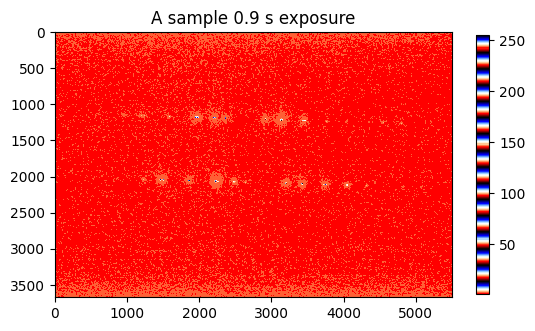

In [4]:
fig, ax = plt.subplots()
im = ax.imshow(np.array(Image.open("C:/Users/tdavd/Desktop/Quantum Astrometry/SharpCap Captures/mz_astrocam_check_img199.png")),
         cmap='flag')
ax.set_title(f'A sample {t_exp} s exposure')
colorbar = fig.colorbar(im, ax=ax, shrink = 0.7)

Create an average of many exposures, hopefully making spots visible.

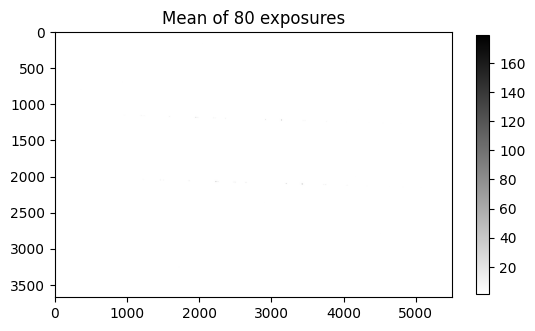

In [5]:
fig, ax = plt.subplots()
avg_img = np.zeros((imgsize_y,imgsize_x))
for imgn in range(4000, 4080):
    avg_img += np.array(Image.open(f"C:/Users/tdavd/Desktop/Quantum Astrometry/SharpCap Captures/mz_astrocam_check_img{imgn}.png"))
avg_img *= 1./80.
im = ax.imshow(avg_img, cmap='binary')
ax.set_title(f'Mean of {85-5} exposures')
colorbar = fig.colorbar(im, ax=ax, shrink = 0.7)

Well, that was useless unless you zoom in. Now for a proper colormap of the above. See how uniform the background is!

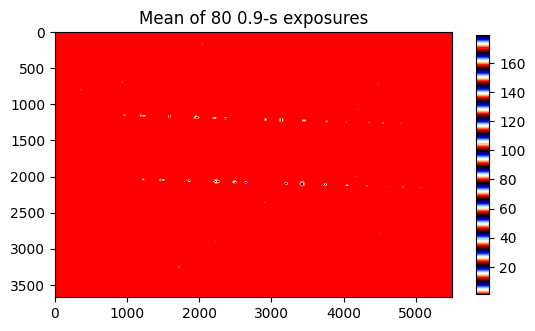

In [6]:
fig, ax = plt.subplots()
im = ax.imshow(avg_img, cmap='flag')
ax.set_title(f'Mean of {80} {t_exp}-s exposures')
colorbar = fig.colorbar(im, ax=ax, shrink = 0.7)

#### Set image paths and spot locations and initialize the spot_df dataframe. Manually.

In [7]:
#manual spot region selection using the above graphs. This is why we have matplotlib widget.
spot_x0_o1 = [ 946,1180,1221,1570,1933,1968,2187,2210,2349,2903,3121,3426,3451,3752,4029,4343,4538,4788]
spot_y0_o1 = [1151,1158,1160,1170,1177,1179,1186,1186,1190,1206,1208,1225,1225,1235,1245,1257,1262,1269]
spot_xf_o1 = [ 980,1212,1249,1599,1965,1989,2206,2226,2371,2925,3149,3444,3470,3767,4040,4350,4549,4800]
spot_yf_o1 = [1162,1169,1169,1182,1199,1195,1204,1204,1210,1228,1237,1244,1243,1252,1257,1264,1271,1279]

spot_x0_o2 = [1210,1445,1489,1844,2213,2246,2466,2491,2630,3184,3398,3709,3738,4031,4310,4621,4808,5057]
spot_y0_o2 = [2040,2041,2044,2053,2059,2065,2071,2072,2074,2091,2089,2106,2106,2119,2129,2139,2144,2151]
spot_xf_o2 = [1230,1472,1509,1868,2240,2268,2485,2510,2656,3215,3445,3731,3758,4054,4323,4631,4830,5075]
spot_yf_o2 = [2051,2062,2063,2074,2086,2085,2091,2092,2096,2113,2124,2127,2125,2132,2137,2145,2152,2159]

#uncertainty-calculating region. Uncertainties will be called "unc" in variable names.
ux0 = 2000
uxf = 3000
uy0 = 1540
uyf = 1560

img_pathname = "C:/Users/tdavd/Desktop/Quantum Astrometry/SharpCap Captures/mz_astrocam_check_img"
#dark_pathname = "C:/Users/tdavd/Desktop/Quantum Astrometry/SharpCap Captures/mz_astrocam_Ar_set2_dark"

spot_df = [] #initialize the array. We're gonna store everything about each spot in this soon-to-be dataframe.

for i in range(len(spot_x0_o1)): ###CHANGE TO 18 EVENTUALLY, 2 FOR TESTING ###
    spot_df.append([1, spot_x0_o1[i], spot_y0_o1[i], spot_xf_o1[i], spot_yf_o1[i]])
    spot_df.append([2, spot_x0_o2[i], spot_y0_o2[i], spot_xf_o2[i], spot_yf_o2[i]])

spot_df = pd.DataFrame(spot_df, columns=['output', 'x_start', 'y_start', 'x_end', 'y_end'])

display_colors = ['#000000', '#2ca02c', '#d62728', '#9467bd', '#ff7f0e', '#D00101', '#D55E00', '#CC79A7', '#26156F', '#69AD5D', '#9066ed', '#6F0C29', '#CC79A7', '#D00101','#000000', '#2ca02c', '#d62728', '#9467bd']

# Duplicating colors above for assignment of both outputs
display_colors_duplicated = []
for color in display_colors:
    display_colors_duplicated.append(color)
    display_colors_duplicated.append(color)

spot_df['display_color'] = display_colors_duplicated

spot_df

output  x_start  y_start  x_end  y_end display_color
0        1      946     1151    980   1162       #000000
1        2     1210     2040   1230   2051       #000000
2        1     1180     1158   1212   1169       #2ca02c
3        2     1445     2041   1472   2062       #2ca02c
4        1     1221     1160   1249   1169       #d62728
5        2     1489     2044   1509   2063       #d62728
6        1     1570     1170   1599   1182       #9467bd
7        2     1844     2053   1868   2074       #9467bd
8        1     1933     1177   1965   1199       #ff7f0e
9        2     2213     2059   2240   2086       #ff7f0e
10       1     1968     1179   1989   1195       #D00101
11       2     2246     2065   2268   2085       #D00101
12       1     2187     1186   2206   1204       #D55E00
13       2     2466     2071   2485   2091       #D55E00
14       1     2210     1186   2226   1204       #CC79A7
15       2     2491     2072   2510   2092       #CC79A7
16       1     2349     1190   2371   1210       #26156F
17       2     2630     2074   2656   2096       #26156F
18       1     2903     1206   2925   1228       #69AD5D
19       2     3184     2091   3215   2113       #69AD5D
20       1     3121     1208   3149   1237       #9066ed
21       2     3398     2089   3445   2124       #9066ed
22       1     3426     1225   3444   1244       #6F0C29
23       2     3709     2106   3731   2127       #6F0C29
24       1     3451     1225   3470   1243       #CC79A7
25       2     3738     2106   3758   2125       #CC79A7
26       1     3752     1235   3767   1252       #D00101
27       2     4031     2119   4054   2132       #D00101
28       1     4029     1245   4040   1257       #000000
29       2     4310     2129   4323   2137       #000000
30       1     4343     1257   4350   1264       #2ca02c
31       2     4621     2139   4631   2145       #2ca02c
32       1     4538     1262   4549   1271       #d62728
33       2     4808     2144   4830   2152       #d62728
34       1     4788     1269   4800   1279       #9467bd
35       2     5057     2151   5075   2159       #9467bd

#### Plot the locations of the spot/unc regions and try to identify wavelengths

The big one is the region we use to identify uncertainty.

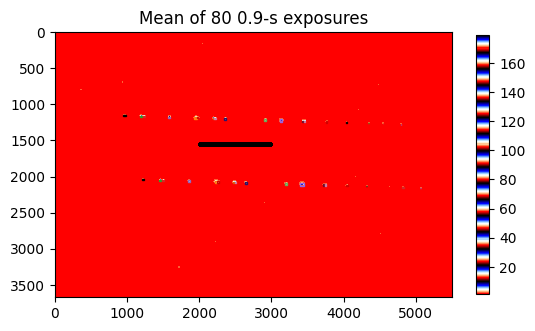

In [8]:
fig, ax = plt.subplots()
im = ax.imshow(avg_img, cmap='flag')
ax.set_title(f'Mean of {85-5} {t_exp}-s exposures')
colorbar = fig.colorbar(im, ax=ax, shrink = 0.7)

#Plot boxes for the wavelenth spots. Use widget to check.
for i, spot in spot_df.iterrows():
    spot_patch = matplotlib.patches.Polygon([[spot['x_start'],spot['y_start']],
                                            [spot['x_start'],spot['y_end']],
                                            [spot['x_end'],spot['y_end']],
                                            [spot['x_end'],spot['y_start']]],
                                            color=spot['display_color'], fill=False)
    ax.add_patch(spot_patch)
    unc_patch = matplotlib.patches.Polygon([[ux0,uy0],[ux0,uyf],[uxf,uyf],[uxf,uy0]],fill=False)
    ax.add_patch(unc_patch)

Find spot centers and assign nominal wavelengths. 

Given the low quality wavelength-pixel relation as will be seen later, this is considered rudimentary and unsolved. The "uncontroversial" ones with lots of sigfigs are the ones that seemed unambiguous from NIST data.

In [9]:
nominal_wls = [696.54300, 706, 706, 714.70410, 727, 727, 738, 738, 750.38680,763.51054,772.37600, 794, 794, 801, 811, 826.45215, 842, 852.14411][::-1]

nominal_wls_doubled = []
for wl in nominal_wls:
    nominal_wls_doubled.append(wl)
    nominal_wls_doubled.append(wl)

spot_df['exp wl'] = nominal_wls_doubled

spot_df['x_center'] = 0.5*(spot_df['x_start']+spot_df['x_end'])
spot_df['y_center'] = 0.5*(spot_df['y_start']+spot_df['y_end'])
spot_df

output  x_start  y_start  x_end  y_end display_color     exp wl  x_center  \
0        1      946     1151    980   1162       #000000  852.14411     963.0   
1        2     1210     2040   1230   2051       #000000  852.14411    1220.0   
2        1     1180     1158   1212   1169       #2ca02c  842.00000    1196.0   
3        2     1445     2041   1472   2062       #2ca02c  842.00000    1458.5   
4        1     1221     1160   1249   1169       #d62728  826.45215    1235.0   
5        2     1489     2044   1509   2063       #d62728  826.45215    1499.0   
6        1     1570     1170   1599   1182       #9467bd  811.00000    1584.5   
7        2     1844     2053   1868   2074       #9467bd  811.00000    1856.0   
8        1     1933     1177   1965   1199       #ff7f0e  801.00000    1949.0   
9        2     2213     2059   2240   2086       #ff7f0e  801.00000    2226.5   
10       1     1968     1179   1989   1195       #D00101  794.00000    1978.5   
11       2     2246     2065   2268   2085       #D00101  794.00000    2257.0   
12       1     2187     1186   2206   1204       #D55E00  794.00000    2196.5   
13       2     2466     2071   2485   2091       #D55E00  794.00000    2475.5   
14       1     2210     1186   2226   1204       #CC79A7  772.37600    2218.0   
15       2     2491     2072   2510   2092       #CC79A7  772.37600    2500.5   
16       1     2349     1190   2371   1210       #26156F  763.51054    2360.0   
17       2     2630     2074   2656   2096       #26156F  763.51054    2643.0   
18       1     2903     1206   2925   1228       #69AD5D  750.38680    2914.0   
19       2     3184     2091   3215   2113       #69AD5D  750.38680    3199.5   
20       1     3121     1208   3149   1237       #9066ed  738.00000    3135.0   
21       2     3398     2089   3445   2124       #9066ed  738.00000    3421.5   
22       1     3426     1225   3444   1244       #6F0C29  738.00000    3435.0   
23       2     3709     2106   3731   2127       #6F0C29  738.00000    3720.0   
24       1     3451     1225   3470   1243       #CC79A7  727.00000    3460.5   
25       2     3738     2106   3758   2125       #CC79A7  727.00000    3748.0   
26       1     3752     1235   3767   1252       #D00101  727.00000    3759.5   
27       2     4031     2119   4054   2132       #D00101  727.00000    4042.5   
28       1     4029     1245   4040   1257       #000000  714.70410    4034.5   
29       2     4310     2129   4323   2137       #000000  714.70410    4316.5   
30       1     4343     1257   4350   1264       #2ca02c  706.00000    4346.5   
31       2     4621     2139   4631   2145       #2ca02c  706.00000    4626.0   
32       1     4538     1262   4549   1271       #d62728  706.00000    4543.5   
33       2     4808     2144   4830   2152       #d62728  706.00000    4819.0   
34       1     4788     1269   4800   1279       #9467bd  696.54300    4794.0   
35       2     5057     2151   5075   2159       #9467bd  696.54300    5066.0   

    y_center  
0     1156.5  
1     2045.5  
2     1163.5  
3     2051.5  
4     1164.5  
5     2053.5  
6     1176.0  
7     2063.5  
8     1188.0  
9     2072.5  
10    1187.0  
11    2075.0  
12    1195.0  
13    2081.0  
14    1195.0  
15    2082.0  
16    1200.0  
17    2085.0  
18    1217.0  
19    2102.0  
20    1222.5  
21    2106.5  
22    1234.5  
23    2116.5  
24    1234.0  
25    2115.5  
26    1243.5  
27    2125.5  
28    1251.0  
29    2133.0  
30    1260.5  
31    2142.0  
32    1266.5  
33    2148.0  
34    1274.0  
35    2155.0

#### Play an animation of a subset of the images. This part's optional but it looks pretty. Epilepsy warning (dim backgrounds flip between colors).

In [21]:
def animate_mz(frames, name_specifier=None, cmap='flag', title=None, interval=100, save=False):
    
    fig, ax = plt.subplots()

    #create the artist list and animation
    imgs = []
    for i, frame in enumerate(frames): 
        img = ax.imshow(frame,origin='lower',cmap=cmap,animated=True)
        imgs.append([img])
    ani = ArtistAnimation(fig, imgs, interval=interval, blit=False, repeat_delay=0)

    if save:
        ani.save(f"mz_ASI183_{name_specifier}.gif")
        
    return ani

In [16]:
#%matplotlib widget #You can also zoom in on animations

MovieWriter ffmpeg unavailable; using Pillow instead.


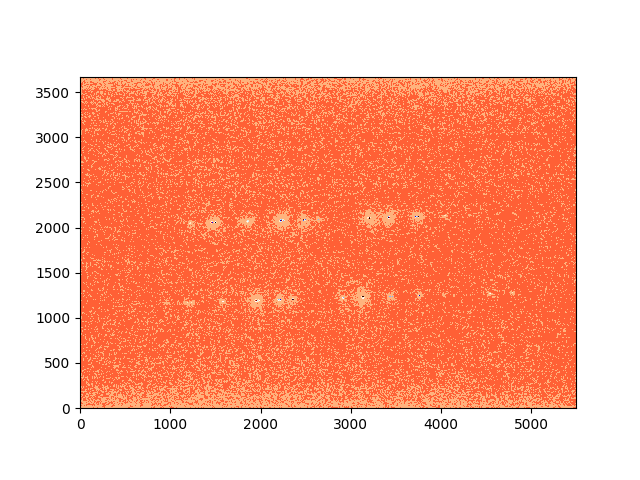

In [24]:
animation_imgn_start = 5
animation_imgn_end = 50

img_pathname = "C:/Users/tdavd/Desktop/Quantum Astrometry/SharpCap Captures/mz_astrocam_check_img"
#dark_pathname = "C:/Users/tdavd/Desktop/Quantum Astrometry/SharpCap Captures/mz_astrocam_Ar_set2_dark"

sample_frames = []
for n in range(animation_imgn_start, animation_imgn_end):
    sample_frames.append(np.array(Image.open(img_pathname + f"{n}.png")))

animate_mz(sample_frames, "mz_ASI183_g50_expt900ms_flag", cmap='flag', save=True)

#### Turn PNGs into signals.

Skip the regions enclosed by |=== and ===| if you have already saved hist_vals and unc_vals!

#### |============================================================================

#### Make smaller 3D arrays w/ dimensions of (imgn, y, x) out of each spot in each image and the uncertainty region. Also subtract darks if you want.

To make sure we don't run out of memory, let's do the following steps in chunks. Only one image is ever loaded into memory at one time and each image is only loaded once, but subsets of it representing spots are kept. It's those subsets (also indexed by which image they're from) that we are chopping into chunks. So, only 100 points (just the chunk size I chose based on previous iterations) of the final signal are calculated at once because each point comes from a ~30 x 30 (at most) 2d array. To have that for all 12,000 for all 36 spots and the uncertainty region at once would be on the order of terabytes to load into memory.

This function's length is in part due to the if statements for whether to use dark frames. I don't think this is slowing its execution down too much, though.

Regarding uncertainty, we assume the background fluctuations are the main source of uncertainty. To account for them in an image, take the mean and std. dev. of the unc region. Assume this is the mean and uncertainty in one pixel's value. In a spot with $N$ pixels, each of which has a background value $v=\mu\pm\sigma$, the sum of N of these random variables is $N\mu\pm\sqrt{N}\sigma$ since uncertainties add in quadrature (not to be confused with N times v, which includes only one random variable and has a greater uncertainty $N\sigma$). We also subtract the background mean times N from the signals, to account for changes in background brightness.

Make sure not to confuse labels for the 2D uncertainty region array with arrays representing the uncertainties in the signal points, which are (number of signals) 1D arrays made only in the final steps. The uncertainty region is typically handled on its own after a loop containing all the other regions. As a result, a few blocks look like this:

for spot in spots:

    do stuff to spot.
    
do stuff to unc region

In [31]:
def calculate_signal():
    #initialize structure of final arrays. The structure is [[signal 1 array],...,[signal N array]]
    unc_arrays = []
    signal_arrays = []
    for i in range(len(spot_df)):
        unc_arrays.append([])
        signal_arrays.append([])

    #start iterating over chunks
    num_chunks = (numStays1+numStays2) // 100 #chunk size of 100 assumed
    for chunk_index in range(num_chunks):

        #Define the signal regions
        spot_3d_img_arrays = [] #1-2-1-2 order
        if use_darks:
            spot_3d_dark_arrays = []
        for i, spot in spot_df.iterrows():
            spot_3d_img_arrays.append(np.zeros((100,spot['y_end']-spot['y_start'],spot['x_end']-spot['x_start']),dtype=np.float32))
            if use_darks:
                spot_3d_dark_arrays.append(np.zeros((100,spot['y_end']-spot['y_start'],spot['x_end']-spot['x_start']),dtype=np.float32))
        #Ditto for the uncertainty region
        unc_3d_img_array = np.zeros((100,(uyf-uy0),(uxf-ux0)),dtype=np.float32) 
        if use_darks:
            unc_3d_dark_array = np.zeros((100,(uyf-uy0),(uxf-ux0)),dtype=np.float32)
        
        #make the 3d arrays (dims are (,,))
        back_pixel_vals = []
        back_pixel_uncs = []
        for j in range(100):
            imgn = j + 1 + 100*chunk_index

            if use_darks:
                #make arrays out of entire PNGs.
                img_array_2d = np.array(Image.open(img_pathname + f'{imgn}.png'), dtype=np.float32)
                dark_array_2d = np.array(Image.open(dark_pathname + f'{imgn}.png'), dtype=np.float32)
                for i, spot in spot_df.iterrows(): #FIXME: just take advantage of the tuple structure of spot_df.iterrows()...
                    spot_3d_img_arrays[i][j-1,:,:] = img_array_2d[spot['y_start']:spot['y_end'],spot['x_start']:spot['x_end']]
                    spot_3d_dark_arrays[i][j-1,:,:] = dark_array_2d[spot['y_start']:spot['y_end'],spot['x_start']:spot['x_end']]
                unc_3d_img_array[j-1,:,:] = img_array_2d[uy0:uyf,ux0:uxf]
                unc_3d_dark_array[j-1,:,:] = dark_array_2d[uy0:uyf,ux0:uxf]
                #calculate arrays representing subsets of the full master dark in the spot regions
                master_dark_spots = []
                for dark_series in spot_3d_dark_arrays:
                    master_dark_spots.append(np.median(dark_series, 0))
                #dark-subtract, changing values in spot_3d_img_arrays
                for i, spot_tuple in enumerate(list(spot_df.iterrows())):
                    for img_arr in spot_3d_img_arrays[i]:
                        img_arr -= master_dark_spots[i]
                #Ditto for uncertainty region:
                master_dark_unc = np.median(unc_3d_dark_array, 0) #median along the image index axis
                for img_arr in unc_3d_img_array:
                    img_arr -= master_dark_unc

            else: #less to do if there's no darks.
                #make an array out of one entire PNG.
                img_array_2d = np.array(Image.open(img_pathname + f'{imgn}.png'), dtype=np.float32)
                #create the 100 x Nx x Ny spot arrays
                for i, spot in spot_df.iterrows():
                    spot_3d_img_arrays[i][j-1,:,:] = img_array_2d[spot['y_start']:spot['y_end'],spot['x_start']:spot['x_end']]
                unc_3d_img_array[j-1,:,:] = img_array_2d[uy0:uyf,ux0:uxf]
                
        #calculate background means, stdevs
        back_pixel_vals = np.mean(unc_3d_img_array, (1,2))
        back_pixel_uncs = np.std(unc_3d_img_array, (1,2))

        #create the final chunk signal and uncertainty arrays from the 3d arrays and append them to the total
        for i, spot_3d_img_array in enumerate(spot_3d_img_arrays):
            spot_pixels = spot_3d_img_array[0].size
            chunk_signal_array = np.sum(spot_3d_img_array, (1,2)) - spot_pixels*np.array(back_pixel_vals)
            chunk_unc_array = np.sqrt(spot_pixels)*np.array(back_pixel_uncs)
            
            for signal_pt, unc_pt in zip(chunk_signal_array, chunk_unc_array):
                signal_arrays[i].append(signal_pt)
                unc_arrays[i].append(unc_pt)

        clear_output()
        print(f"Chunk {1+chunk_index}/{num_chunks} finished.")

    return signal_arrays, unc_arrays
    
#takes about 20s per 100 images.

In [32]:
signal_arrays, unc_arrays = calculate_signal()

spot_df['hist_vals'] = signal_arrays
spot_df['unc_vals'] = unc_arrays
spot_df

Chunk 120/120 finished.


output  x_start  y_start  x_end  y_end display_color     exp wl  x_center  \
0        1      946     1151    980   1162       #000000  852.14411     963.0   
1        2     1210     2040   1230   2051       #000000  852.14411    1220.0   
2        1     1180     1158   1212   1169       #2ca02c  842.00000    1196.0   
3        2     1445     2041   1472   2062       #2ca02c  842.00000    1458.5   
4        1     1221     1160   1249   1169       #d62728  826.45215    1235.0   
5        2     1489     2044   1509   2063       #d62728  826.45215    1499.0   
6        1     1570     1170   1599   1182       #9467bd  811.00000    1584.5   
7        2     1844     2053   1868   2074       #9467bd  811.00000    1856.0   
8        1     1933     1177   1965   1199       #ff7f0e  801.00000    1949.0   
9        2     2213     2059   2240   2086       #ff7f0e  801.00000    2226.5   
10       1     1968     1179   1989   1195       #D00101  794.00000    1978.5   
11       2     2246     2065   2268   2085       #D00101  794.00000    2257.0   
12       1     2187     1186   2206   1204       #D55E00  794.00000    2196.5   
13       2     2466     2071   2485   2091       #D55E00  794.00000    2475.5   
14       1     2210     1186   2226   1204       #CC79A7  772.37600    2218.0   
15       2     2491     2072   2510   2092       #CC79A7  772.37600    2500.5   
16       1     2349     1190   2371   1210       #26156F  763.51054    2360.0   
17       2     2630     2074   2656   2096       #26156F  763.51054    2643.0   
18       1     2903     1206   2925   1228       #69AD5D  750.38680    2914.0   
19       2     3184     2091   3215   2113       #69AD5D  750.38680    3199.5   
20       1     3121     1208   3149   1237       #9066ed  738.00000    3135.0   
21       2     3398     2089   3445   2124       #9066ed  738.00000    3421.5   
22       1     3426     1225   3444   1244       #6F0C29  738.00000    3435.0   
23       2     3709     2106   3731   2127       #6F0C29  738.00000    3720.0   
24       1     3451     1225   3470   1243       #CC79A7  727.00000    3460.5   
25       2     3738     2106   3758   2125       #CC79A7  727.00000    3748.0   
26       1     3752     1235   3767   1252       #D00101  727.00000    3759.5   
27       2     4031     2119   4054   2132       #D00101  727.00000    4042.5   
28       1     4029     1245   4040   1257       #000000  714.70410    4034.5   
29       2     4310     2129   4323   2137       #000000  714.70410    4316.5   
30       1     4343     1257   4350   1264       #2ca02c  706.00000    4346.5   
31       2     4621     2139   4631   2145       #2ca02c  706.00000    4626.0   
32       1     4538     1262   4549   1271       #d62728  706.00000    4543.5   
33       2     4808     2144   4830   2152       #d62728  706.00000    4819.0   
34       1     4788     1269   4800   1279       #9467bd  696.54300    4794.0   
35       2     5057     2151   5075   2159       #9467bd  696.54300    5066.0   

    y_center                                          hist_vals  \
0     1156.5  [473.7881, 450.90033, 420.95642, 307.3954, 277...   
1     2045.5  [513.993, 526.05896, 575.09204, 555.76196, 591...   
2     1163.5  [1276.3888, 1184.4944, 982.5472, 633.01917, 52...   
3     2051.5  [2351.291, 2480.4612, 2758.5461, 2770.6958, 29...   
4     1164.5  [707.5738, 660.6494, 562.6872, 391.3092, 362.4...   
5     2053.5  [1784.897, 1857.011, 1991.068, 1903.498, 1990....   
6     1176.0  [1236.3162, 1139.4207, 970.4728, 677.9508, 601...   
7     2063.5  [3335.1475, 3416.2988, 3704.3745, 3555.6184, 3...   
8     1188.0  [9634.777, 9634.988, 9502.095, 8250.038, 7945....   
9     2072.5  [2961.2314, 2971.4502, 3200.5596, 3484.4658, 3...   
10    1187.0  [1503.0984, 1610.1992, 1839.2495, 2001.7456, 2...   
11    2075.0  [3666.9858, 3511.118, 3177.184, 2346.524, 2076...   
12    1195.0  [499.20728, 426.30994, 326.3612, 218.8482, 227...   
13    2081.0  [4177.897, 4240.0107, 4400.068, 4012.498, 3987...   
1

In [33]:
for i, spot in spot_df.iterrows():
    name = f"f25A/ASI183_f25A_wavelength{1+i//2}_out{spot['output']}"
    file_name = name
    ufile_name = name + "_unc"
    np.save(file_name,spot_df.loc[i, 'hist_vals'])
    np.save(ufile_name,spot_df.loc[i, 'unc_vals'])

#### ============================================================================|

#### Load saved arrays and assign into spot_df.

In [10]:
# Loading previously made hist_val files into current notebook kernel
hist_vals = []
unc_vals = []
for i, spot in spot_df.iterrows():
    name = f"f25A_Ar/ASI183_f25A_wavelength{1+i//2}_out{spot['output']}"
    file_name = name + ".npy"
    ufile_name = name + "_unc.npy"
    hist_vals.append(np.load(file_name))
    unc_vals.append(np.load(ufile_name))
        
spot_df['hist_vals'] = hist_vals
spot_df['unc_vals'] = unc_vals

spot_df

output  x_start  y_start  x_end  y_end display_color     exp wl  x_center  \
0        1      946     1151    980   1162       #000000  852.14411     963.0   
1        2     1210     2040   1230   2051       #000000  852.14411    1220.0   
2        1     1180     1158   1212   1169       #2ca02c  842.00000    1196.0   
3        2     1445     2041   1472   2062       #2ca02c  842.00000    1458.5   
4        1     1221     1160   1249   1169       #d62728  826.45215    1235.0   
5        2     1489     2044   1509   2063       #d62728  826.45215    1499.0   
6        1     1570     1170   1599   1182       #9467bd  811.00000    1584.5   
7        2     1844     2053   1868   2074       #9467bd  811.00000    1856.0   
8        1     1933     1177   1965   1199       #ff7f0e  801.00000    1949.0   
9        2     2213     2059   2240   2086       #ff7f0e  801.00000    2226.5   
10       1     1968     1179   1989   1195       #D00101  794.00000    1978.5   
11       2     2246     2065   2268   2085       #D00101  794.00000    2257.0   
12       1     2187     1186   2206   1204       #D55E00  794.00000    2196.5   
13       2     2466     2071   2485   2091       #D55E00  794.00000    2475.5   
14       1     2210     1186   2226   1204       #CC79A7  772.37600    2218.0   
15       2     2491     2072   2510   2092       #CC79A7  772.37600    2500.5   
16       1     2349     1190   2371   1210       #26156F  763.51054    2360.0   
17       2     2630     2074   2656   2096       #26156F  763.51054    2643.0   
18       1     2903     1206   2925   1228       #69AD5D  750.38680    2914.0   
19       2     3184     2091   3215   2113       #69AD5D  750.38680    3199.5   
20       1     3121     1208   3149   1237       #9066ed  738.00000    3135.0   
21       2     3398     2089   3445   2124       #9066ed  738.00000    3421.5   
22       1     3426     1225   3444   1244       #6F0C29  738.00000    3435.0   
23       2     3709     2106   3731   2127       #6F0C29  738.00000    3720.0   
24       1     3451     1225   3470   1243       #CC79A7  727.00000    3460.5   
25       2     3738     2106   3758   2125       #CC79A7  727.00000    3748.0   
26       1     3752     1235   3767   1252       #D00101  727.00000    3759.5   
27       2     4031     2119   4054   2132       #D00101  727.00000    4042.5   
28       1     4029     1245   4040   1257       #000000  714.70410    4034.5   
29       2     4310     2129   4323   2137       #000000  714.70410    4316.5   
30       1     4343     1257   4350   1264       #2ca02c  706.00000    4346.5   
31       2     4621     2139   4631   2145       #2ca02c  706.00000    4626.0   
32       1     4538     1262   4549   1271       #d62728  706.00000    4543.5   
33       2     4808     2144   4830   2152       #d62728  706.00000    4819.0   
34       1     4788     1269   4800   1279       #9467bd  696.54300    4794.0   
35       2     5057     2151   5075   2159       #9467bd  696.54300    5066.0   

    y_center                                          hist_vals  \
0     1156.5  [473.7881, 450.90033, 420.95642, 307.3954, 277...   
1     2045.5  [513.993, 526.05896, 575.09204, 555.76196, 591...   
2     1163.5  [1276.3888, 1184.4944, 982.5472, 633.01917, 52...   
3     2051.5  [2351.291, 2480.4612, 2758.5461, 2770.6958, 29...   
4     1164.5  [707.5738, 660.6494, 562.6872, 391.3092, 362.4...   
5     2053.5  [1784.897, 1857.011, 1991.068, 1903.498, 1990....   
6     1176.0  [1236.3162, 1139.4207, 970.4728, 677.9508, 601...   
7     2063.5  [3335.1475, 3416.2988, 3704.3745, 3555.6184, 3...   
8     1188.0  [9634.777, 9634.988, 9502.095, 8250.038, 7945....   
9     2072.5  [2961.2314, 2971.4502, 3200.5596, 3484.4658, 3...   
10    1187.0  [1503.0984, 1610.1992, 1839.2495, 2001.7456, 2...   
11    2075.0  [3666.9858, 3511.118, 3177.184, 2346.524, 2076...   
12    1195.0  [499.20728, 426.30994, 326.3612, 218.8482, 227...   
13    2081.0  [4177.897, 4240.0107, 4400.068, 4012.498, 3987...   
1

#### Graph created histograms. The name "histogram" is a relic of the Timepix analysis.

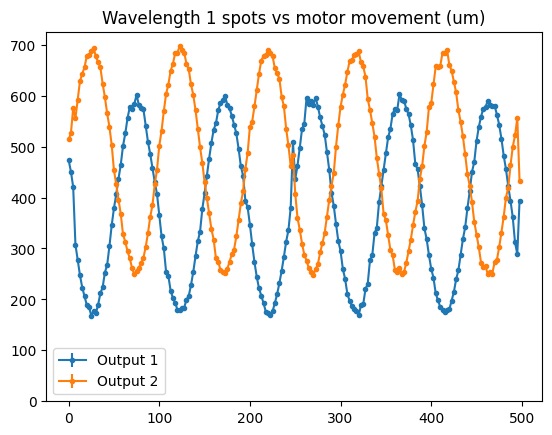

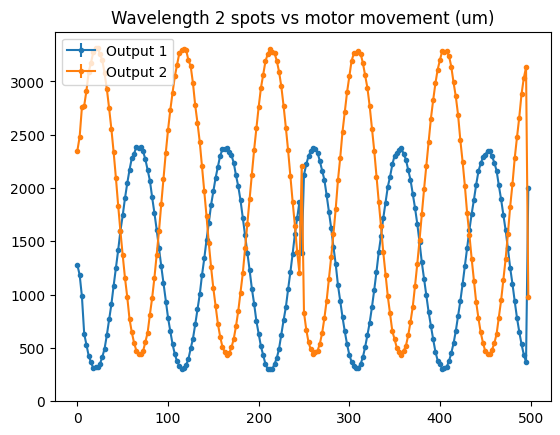

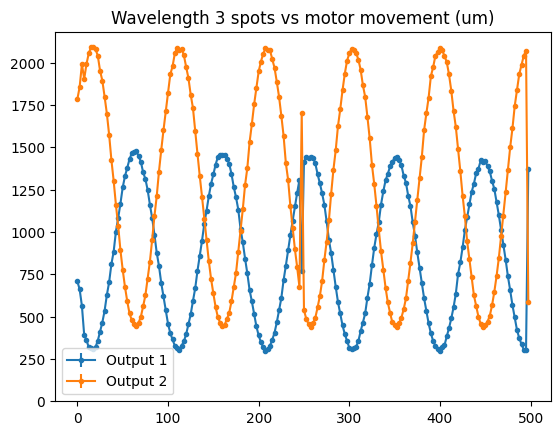

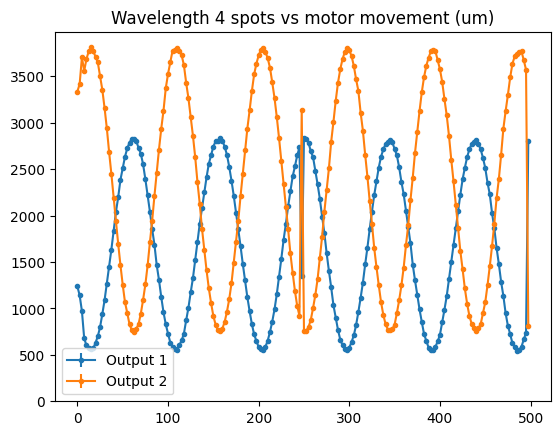

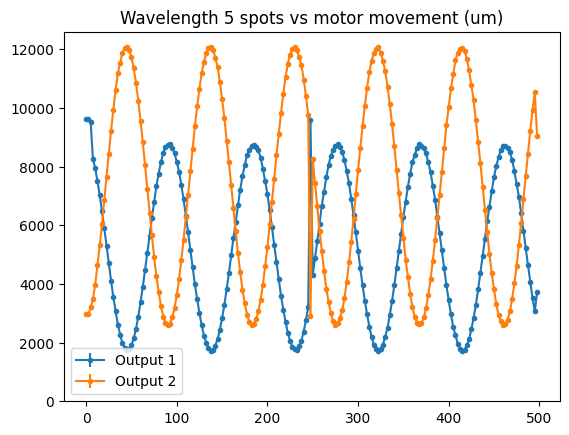

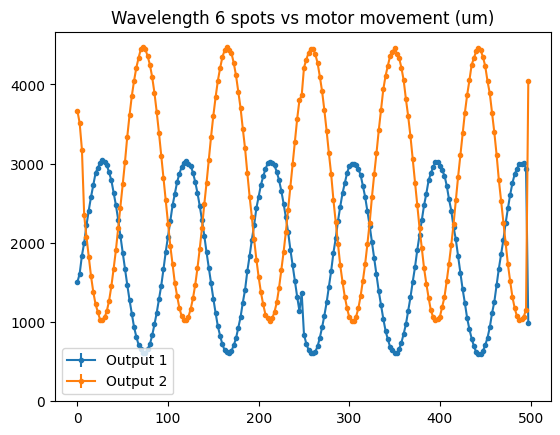

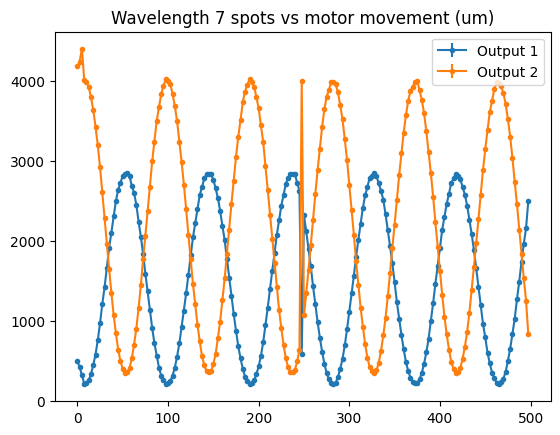

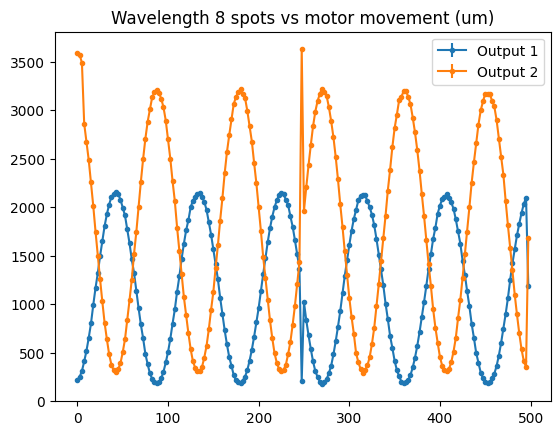

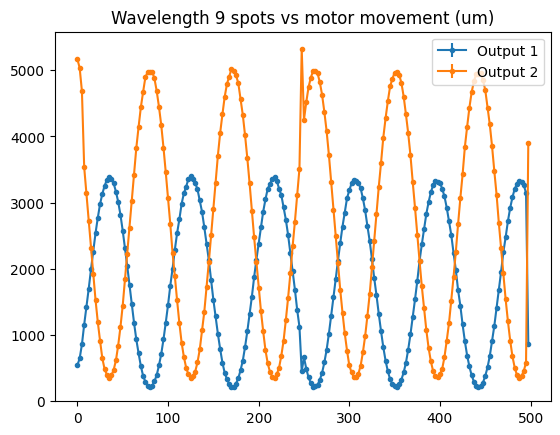

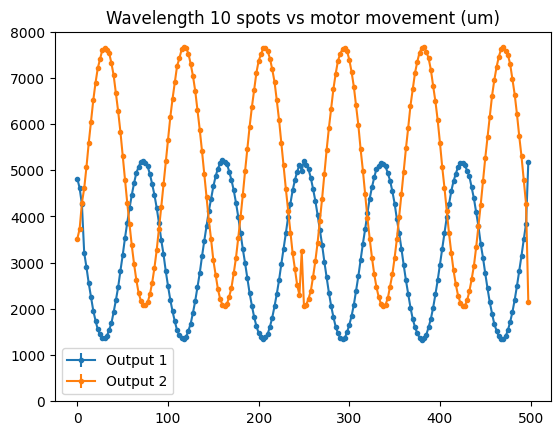

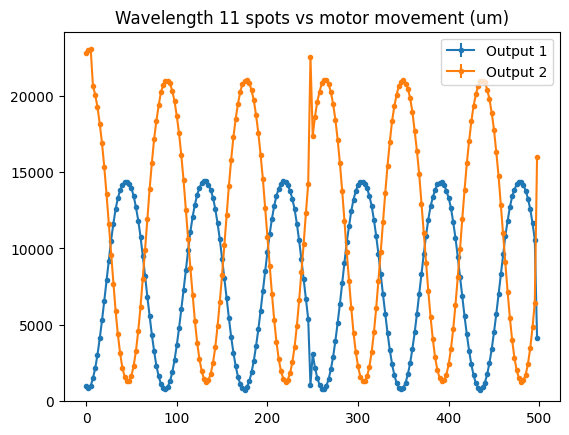

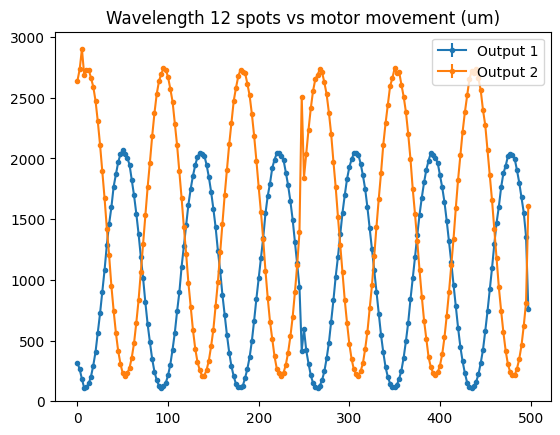

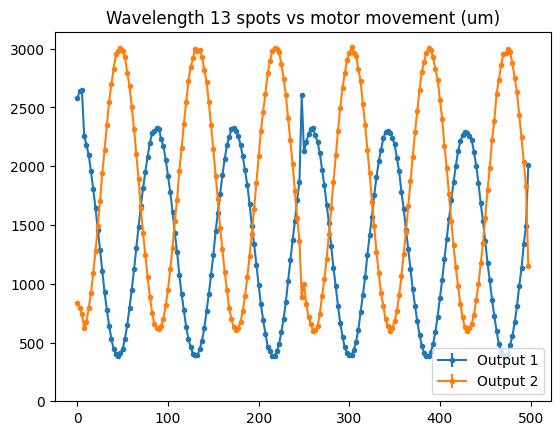

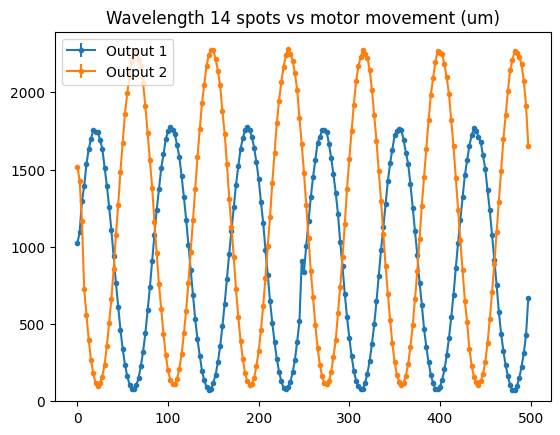

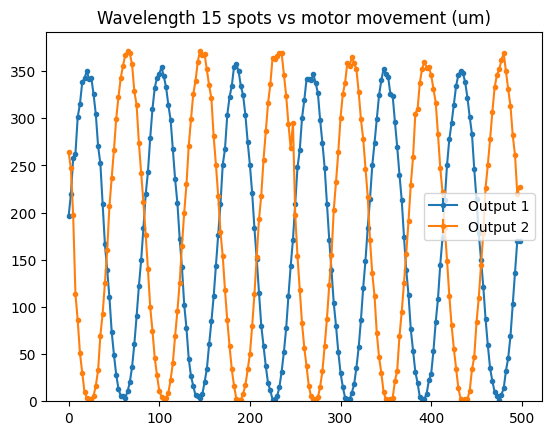

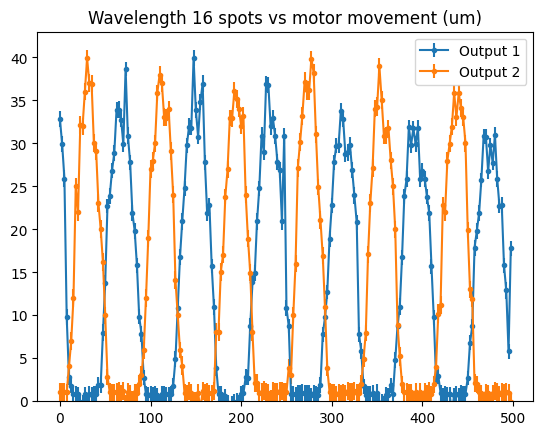

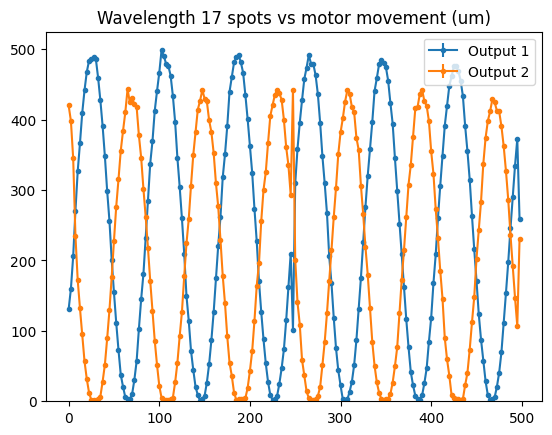

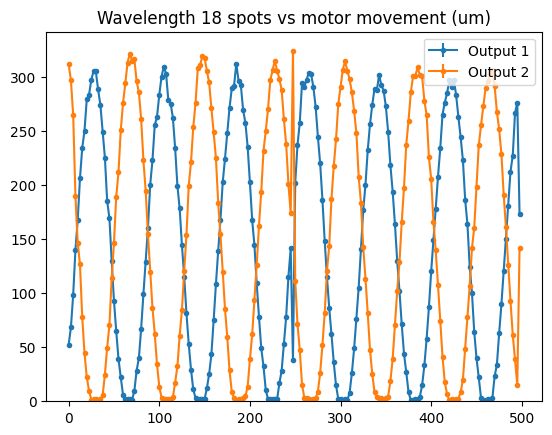

In [11]:
p0 = 0
pf = 200


for i, spot in spot_df.iloc[::2].iterrows():
    output_1 = spot_df.iloc[i]
    output_2 = spot_df.iloc[i+1]

    if i == 1:
        print(output_1['hist_vals'])

    fig, ax = plt.subplots()

    ax.errorbar(displacements[p0:pf], output_1['hist_vals'][p0:pf], yerr=output_1['unc_vals'][p0:pf], marker='.', label=f"Output {output_1['output']}")
    ax.errorbar(displacements[p0:pf], output_2['hist_vals'][p0:pf], yerr=output_2['unc_vals'][p0:pf], marker='.', label=f"Output {output_2['output']}")

    ax.set_ylim(bottom=0)
    
    ax.set_title(f"Wavelength {1+i//2} spots vs motor movement (um)")
    ax.legend()

#### Calculate visibilities and their uncertainties.

In [12]:
#FIXME: it's giving me some negative values for uncertainty in visibility
#current solution: just use the absolute value

visibility_uarrays = []
for i, spot in spot_df.iloc[::2].iterrows():
    output_1 = spot_df.iloc[i]
    output_2 = spot_df.iloc[i+1]

    output_1_uarray = unp.uarray(output_1['hist_vals'], output_1['unc_vals'])
    output_2_uarray = unp.uarray(output_2['hist_vals'], output_2['unc_vals']) 
    
    spot_visibility_uarray = (output_1_uarray - output_2_uarray) / (output_1_uarray + output_2_uarray)
    visibility_uarrays.append(spot_visibility_uarray)
    visibility_uarrays.append(spot_visibility_uarray)

vis_vals = []
vis_uncs = []
for vis_uarray in visibility_uarrays:
    vis_vals.append([])
    vis_uncs.append([])
    for val_unc in vis_uarray:
        vis_vals[-1].append(val_unc.n)
        vis_uncs[-1].append(val_unc.s)

spot_df['vis_vals'] = vis_vals
spot_df['vis_uncs'] = vis_uncs

#### |============================================================================

In [39]:
#save visibility data
for i, spot in spot_df.iloc[::2].iterrows():
    name = f"f25A_Ar/ASI183_f25A_wavelength{1+i//2}_out{spot['output']}_vis"
    file_name = name
    ufile_name = name + "_unc"
    np.save(file_name,spot_df.loc[i, 'vis_vals'])
    np.save(ufile_name,spot_df.loc[i, 'vis_uncs'])

#### ============================================================================|

#### RESOLVE: Do I need to get values for what wavelengths these points are at in order to fit? Do I at least need nontrivial estimates? Keep going until I am blocked by not having...

#### Fourier Analysis

Choose only the first motor's movement for a good FT and a prospective good fit (different prism angles -> different frequencies)

In [13]:
#Limits on what part of signal to be analyzed (um)
model_start = 0.0
model_end = 2.5 * 8000 

# Finding closest index in bin_centers_rt array to above values
start_index = np.argmin(np.abs(displacements-model_start))
end_index = np.argmin(np.abs(displacements-model_end))
model_size = end_index - start_index

print(f"The model will start at index {start_index} and end at {end_index} within the value arrays.")

The model will start at index 0 and end at 8000 within the value arrays.


The remaining blocks do not have uncertainty in them. They're only graphs, so it's not essential.

In [14]:
# Creating fft values using np.fft.fft
frequencies = np.fft.fftfreq(model_size, displacements[1] - displacements[0])
fft_vals = []
fft_vis_vals = []

for i, spot in spot_df.iterrows():
    spot_fft = np.fft.fft(spot['hist_vals'][start_index:end_index])
    fft_vals.append(spot_fft)
    
    if i % 2 == 0:
        visibility_fft = np.fft.fft(spot['vis_vals'][start_index:end_index])
        fft_vis_vals.append(visibility_fft)
        fft_vis_vals.append(visibility_fft)
        
spot_df['fft_vals'] = fft_vals
spot_df['fft_vis_vals'] = fft_vis_vals

#### Signal Fourier transforms

In [18]:
#%matplotlib widget

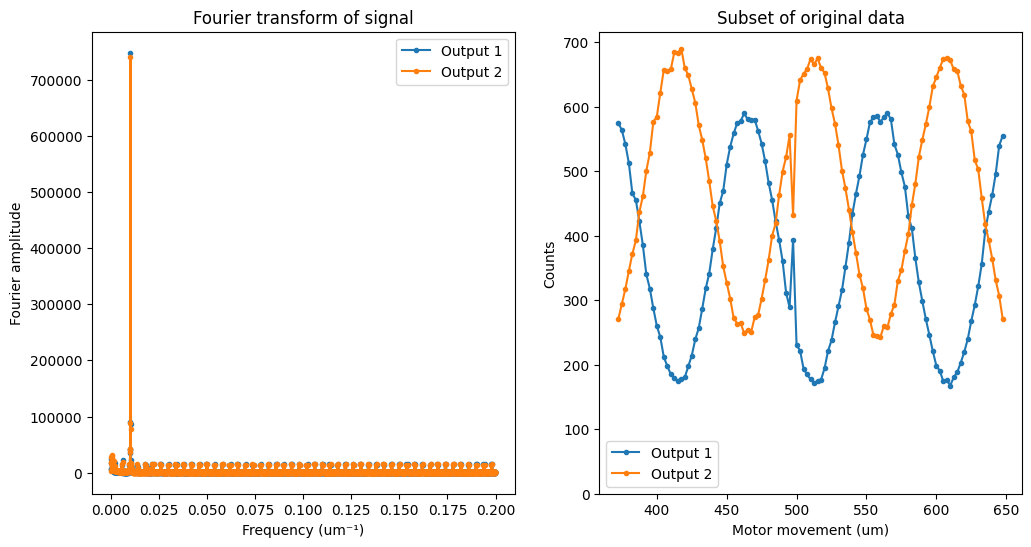

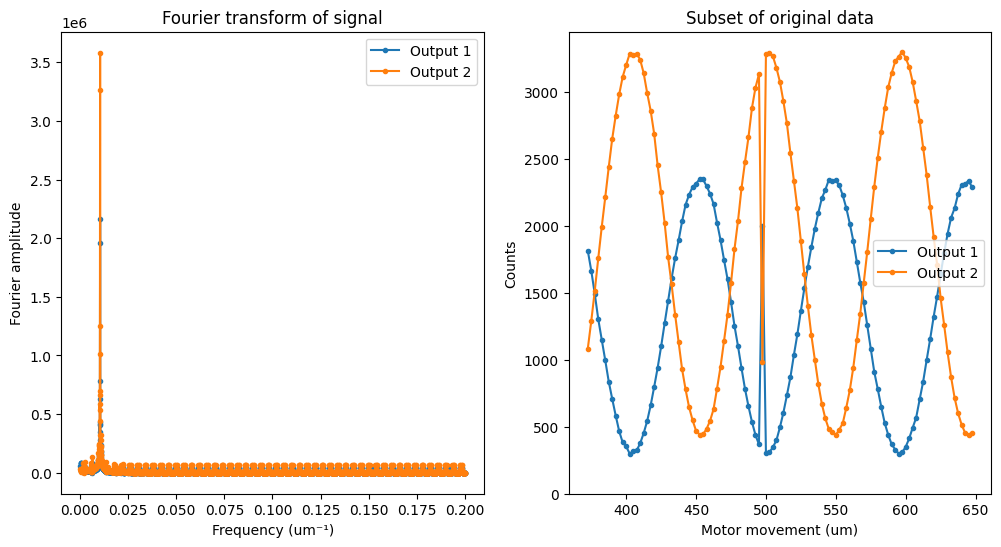

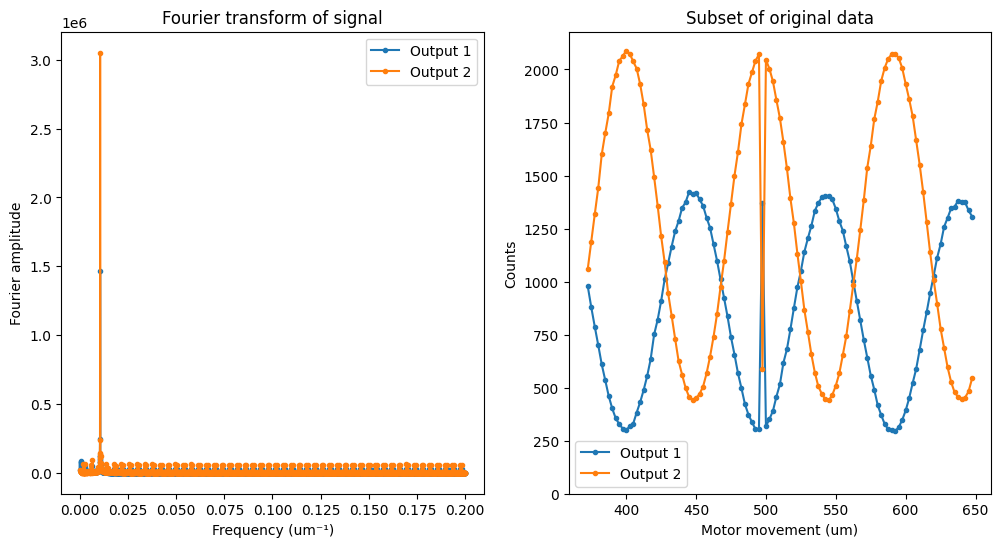

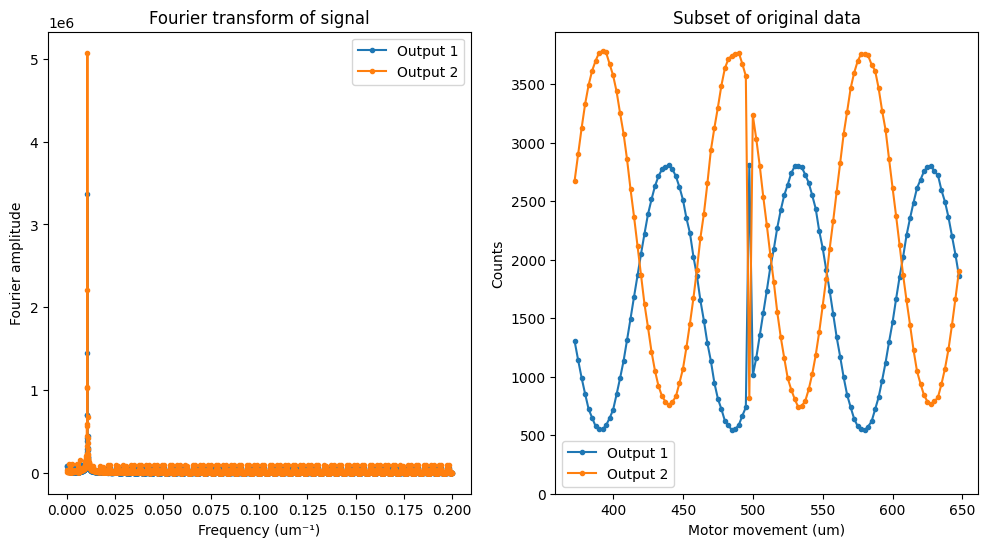

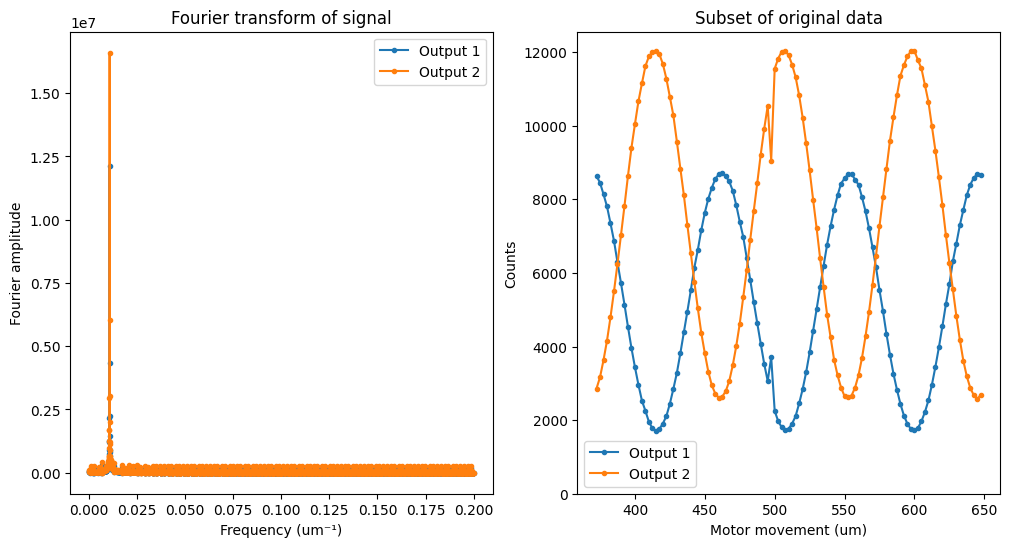

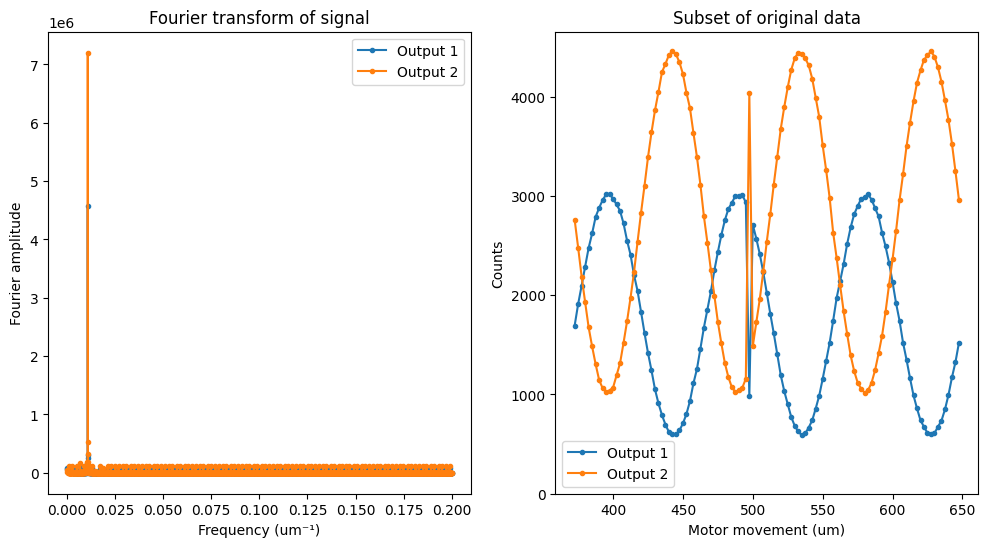

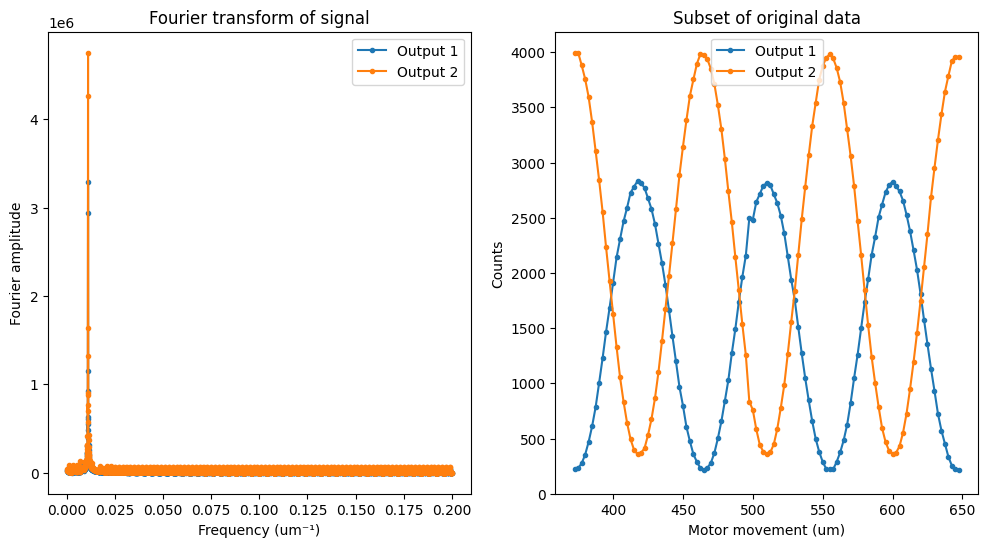

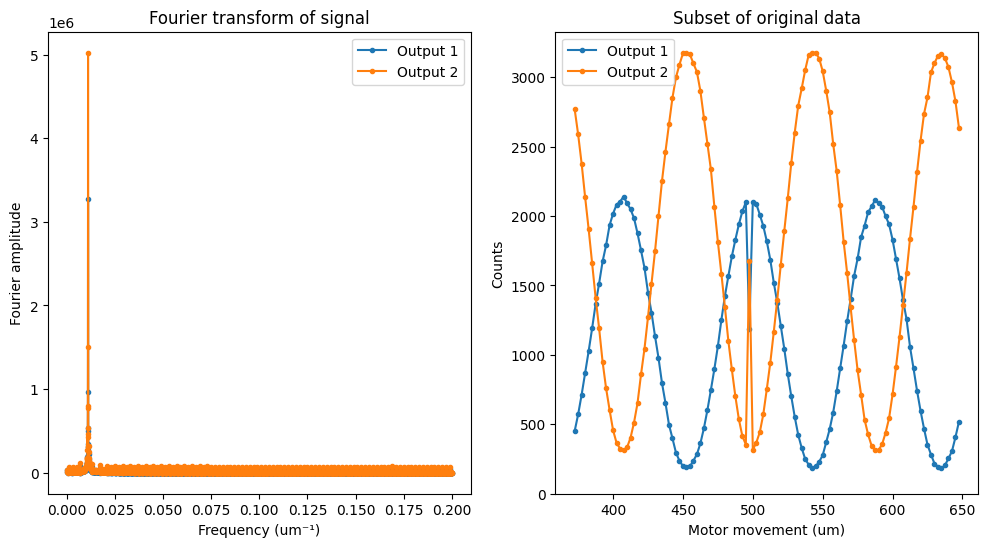

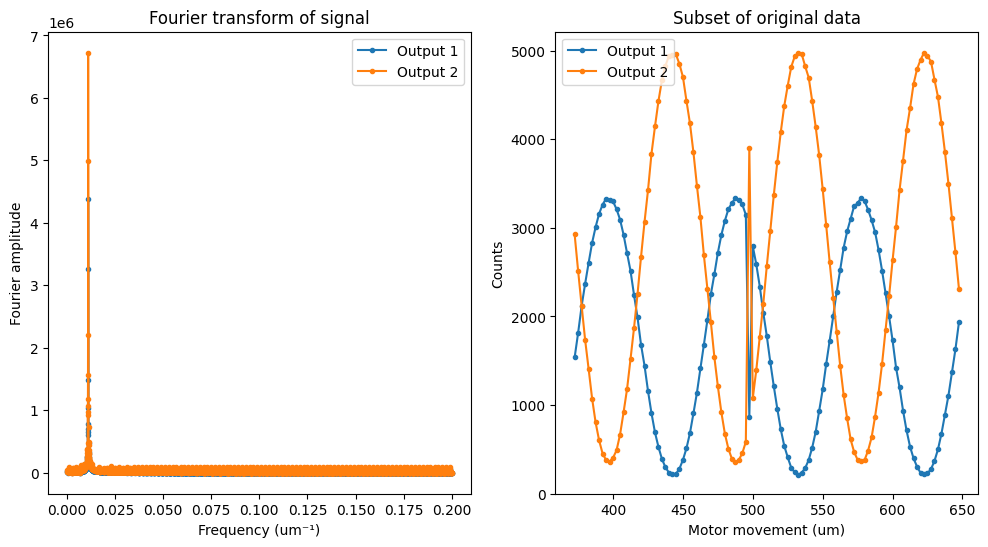

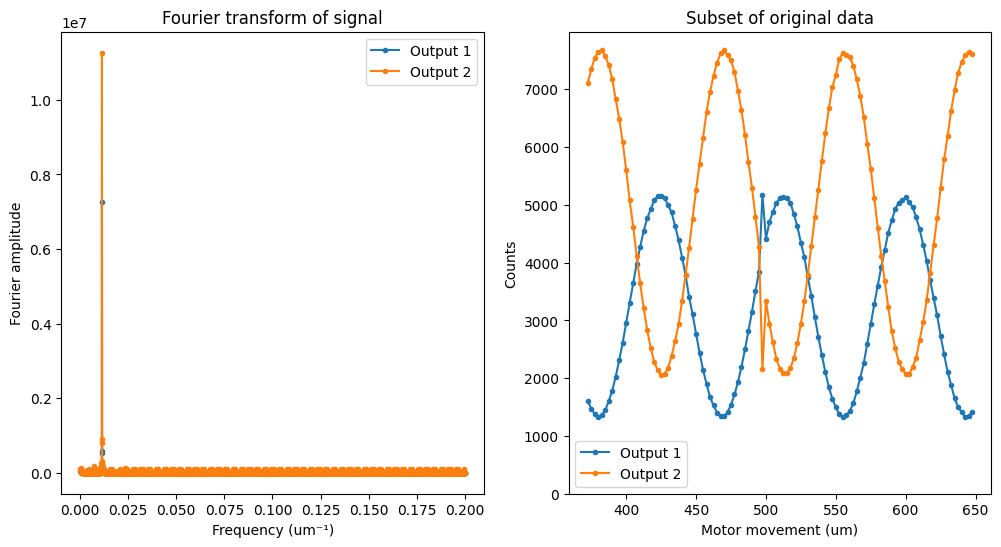

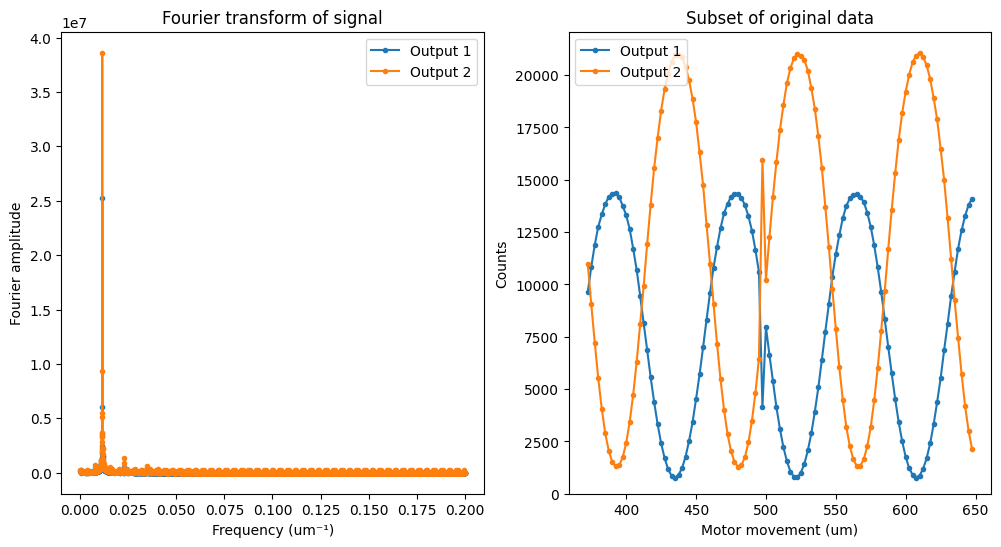

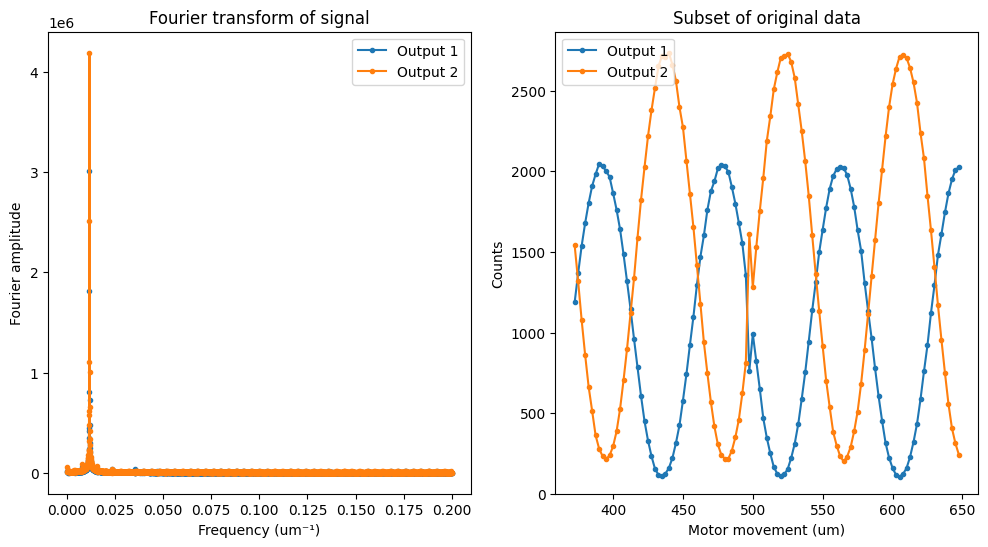

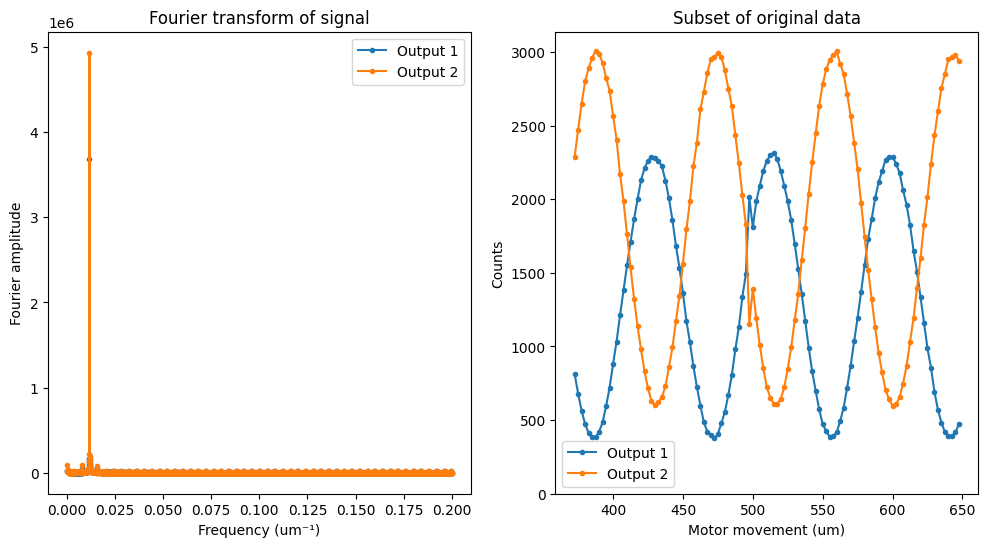

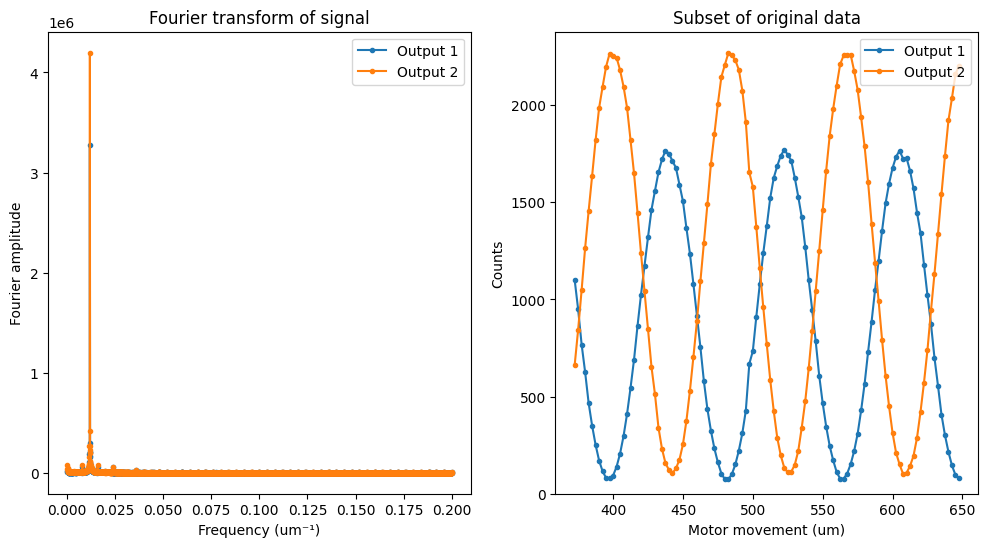

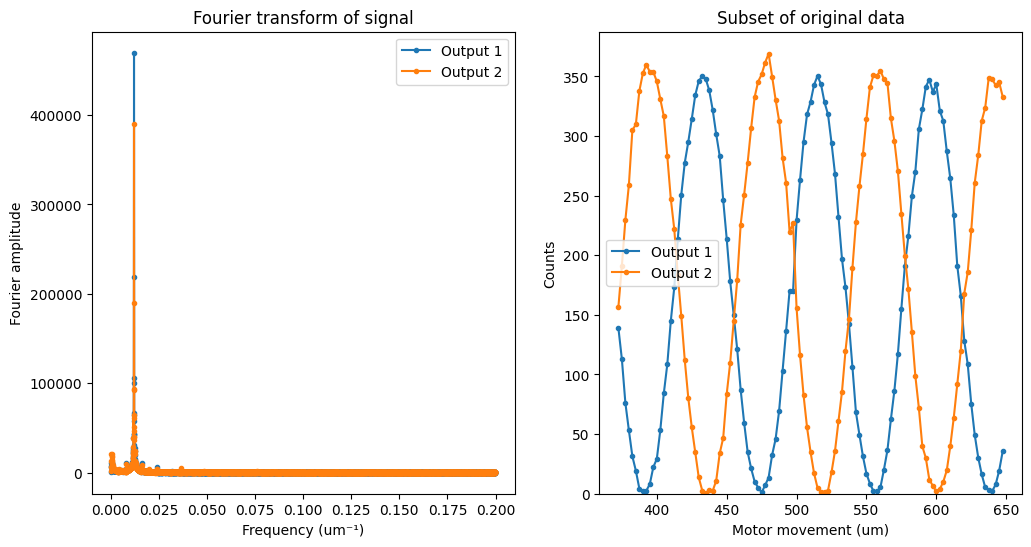

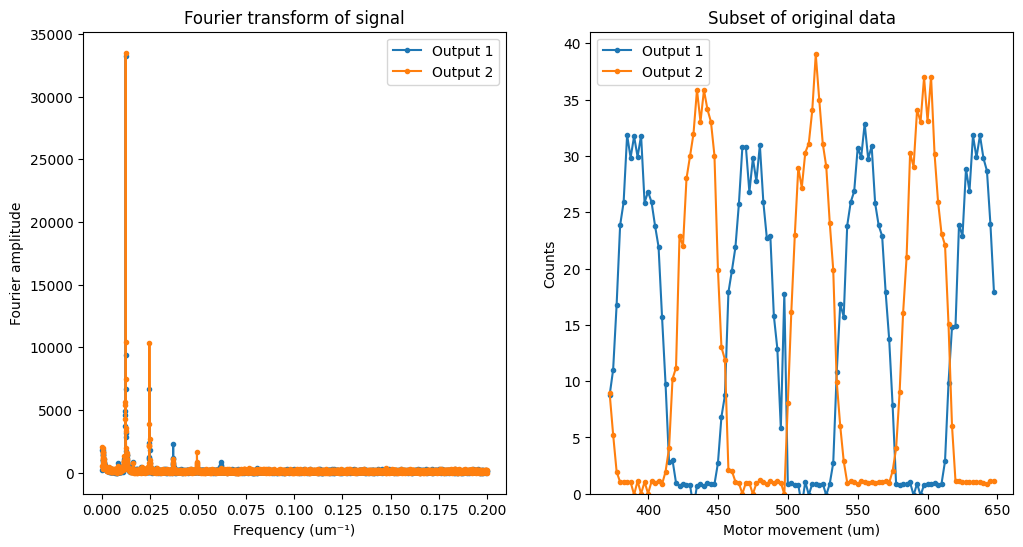

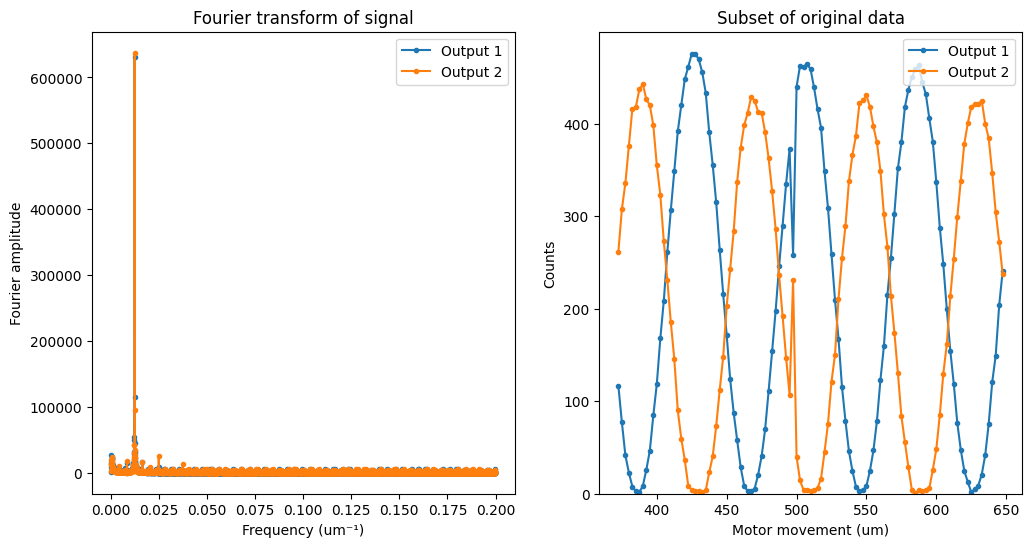

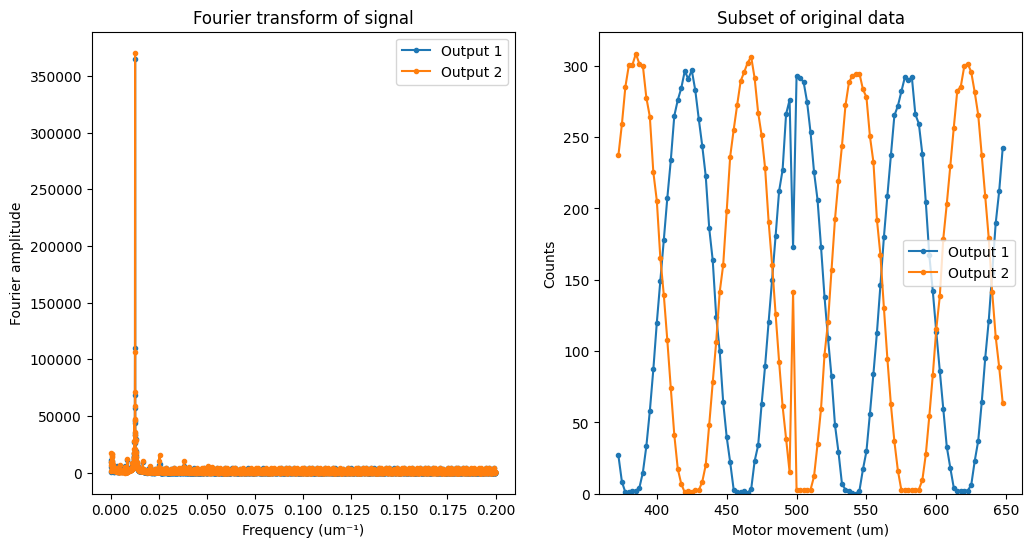

In [15]:
#signal graph sample limits
i_0 = 149
i_f = 260

o1_fourier_peaks = []
o2_fourier_peaks = []
for i, spot in spot_df.iloc[::2].iterrows():
    fig, ax = plt.subplots(ncols=2,figsize=(12,6))
    
    output_1 = spot_df.iloc[i]
    output_2 = spot_df.iloc[i+1]

    # Below plots the modulus of the fft values, and doesn't display points after the nyquist frequency
    ax[0].plot(frequencies[5:model_size//2], np.abs(output_1['fft_vals'][5:model_size//2]), marker='.', label='Output 1')
    ax[0].plot(frequencies[5:model_size//2], np.abs(output_2['fft_vals'][5:model_size//2]), marker='.', label='Output 2')
    #indexed to ignore the 0-spike

    #it graphs 
    o1_fourier_peaks.append( np.abs(output_1['fft_vals'][ output_1['fft_vals'][5:model_size//2].argmax() + 5 ]) )
    o2_fourier_peaks.append( np.abs(output_2['fft_vals'][ output_2['fft_vals'][5:model_size//2].argmax() + 5 ]) )

    #int_freq = find_int_freq(spot['wavelength(nm)'])
    #ax[0].axvline(x=int_freq, color='k', ls='--', label=f'Expected interference frequency at {int_freq:.3f} {time_div_label}⁻¹')

    ax[0].set_xlabel("Frequency (um⁻¹)")
    ax[0].set_ylabel("Fourier amplitude")
    ax[0].set_title(f"Fourier transform of signal")
    ax[0].legend()

    # Time domain from before being modeled
    #plt.subplot(122)
    #plt.plot(bin_centers_rt, output_1['hist_vals'], marker='.', label=f"Output {output_1['#output']}")
    #plt.plot(bin_centers_rt, output_2['hist_vals'], marker='.', label=f"Output {output_2['#output']}")

    ax[1].plot(displacements[i_0:i_f], output_1['hist_vals'][i_0:i_f], marker='.', label=f"Output {output_1['output']}")
    ax[1].plot(displacements[i_0:i_f], output_2['hist_vals'][i_0:i_f], marker='.', label=f"Output {output_2['output']}")

    #plt.axvline(x=model_start, color='Black', ls='--')
    #plt.axvline(x=model_end, color='Black', ls='--')

    ax[1].set_ylim(bottom=0)

    ax[1].set_title(f"Subset of original data")
    ax[1].set_xlabel(f"Motor movement (um)")
    ax[1].set_ylabel("Counts")
    ax[1].legend()

    #fig.tight_layout()

#### Fourier transforms of visibilities

[0.0103  0.01045 0.01045 0.01065 0.01085 0.01085 0.011   0.011   0.01105
 0.0114  0.01155 0.01175 0.01175 0.01195 0.01215 0.01235 0.0125  0.0127 ]


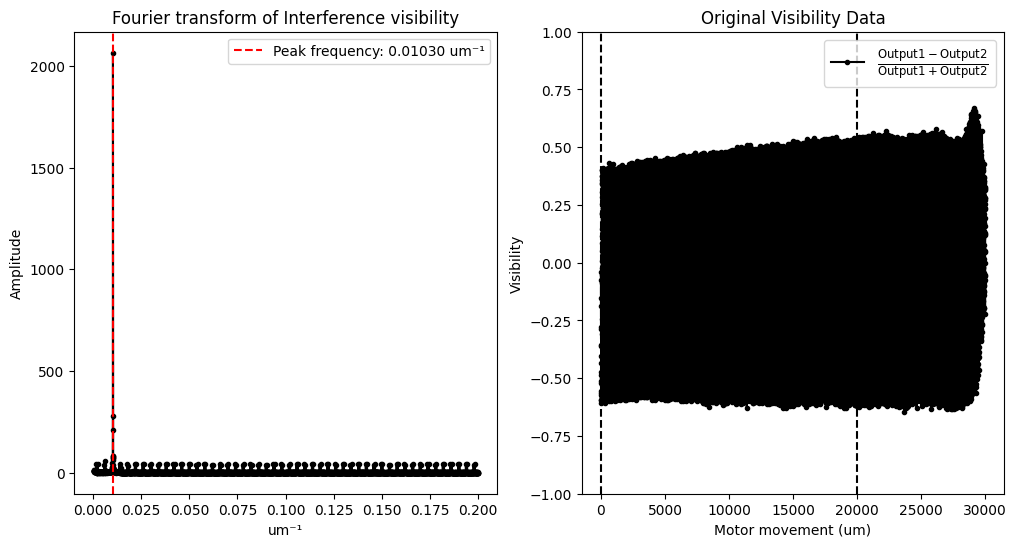

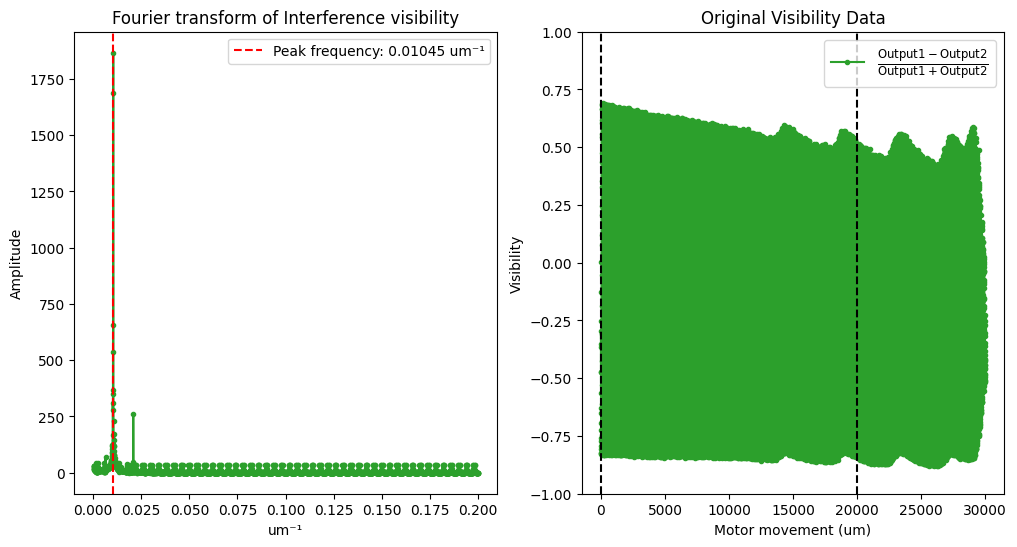

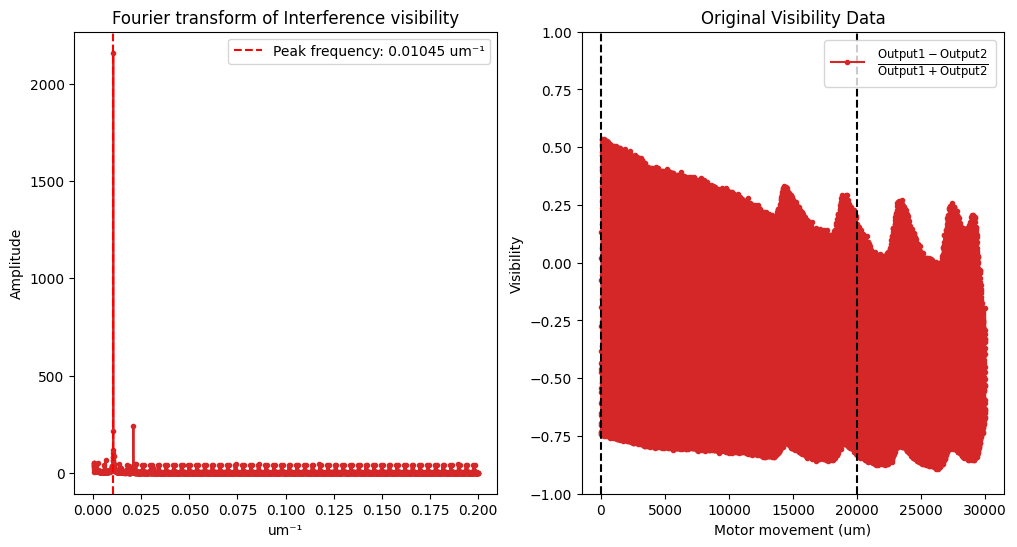

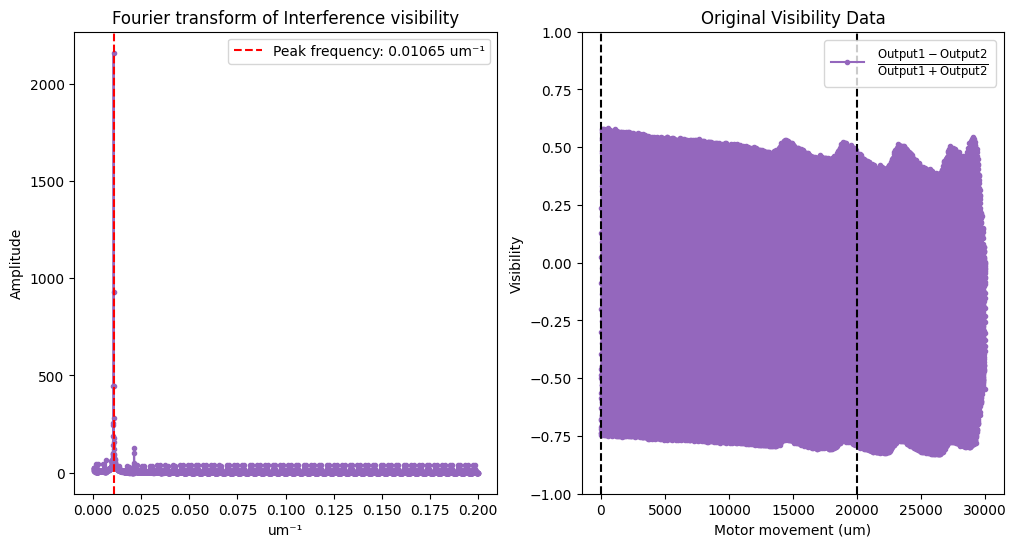

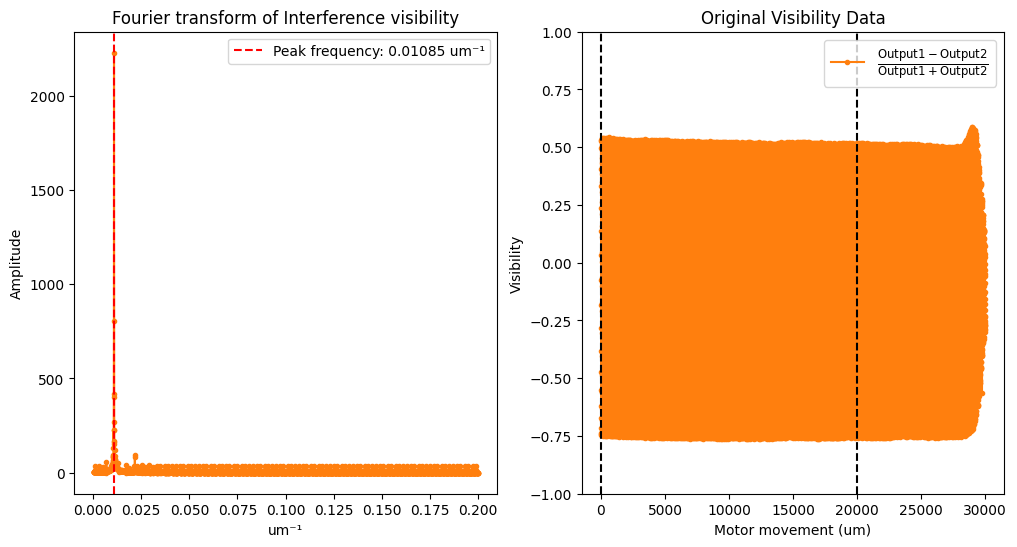

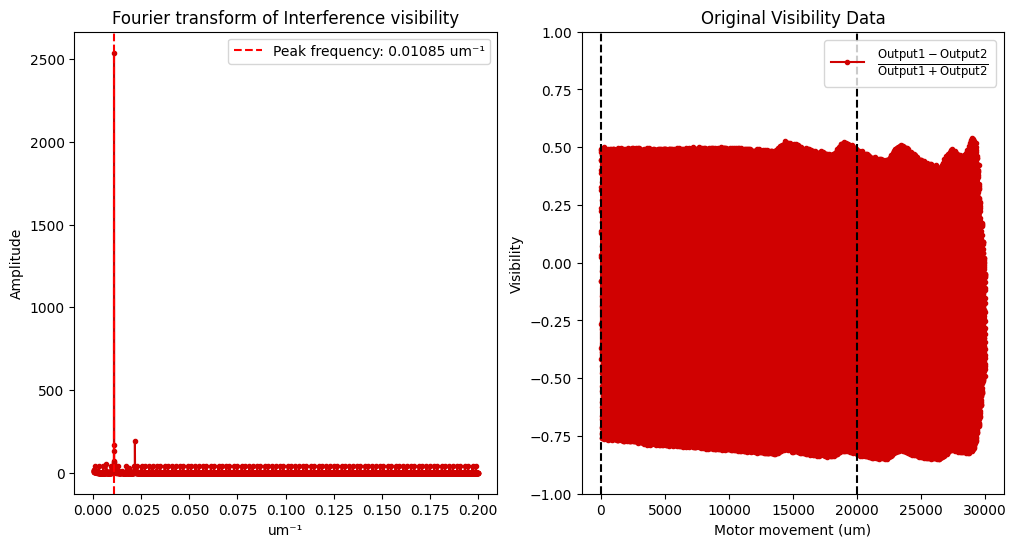

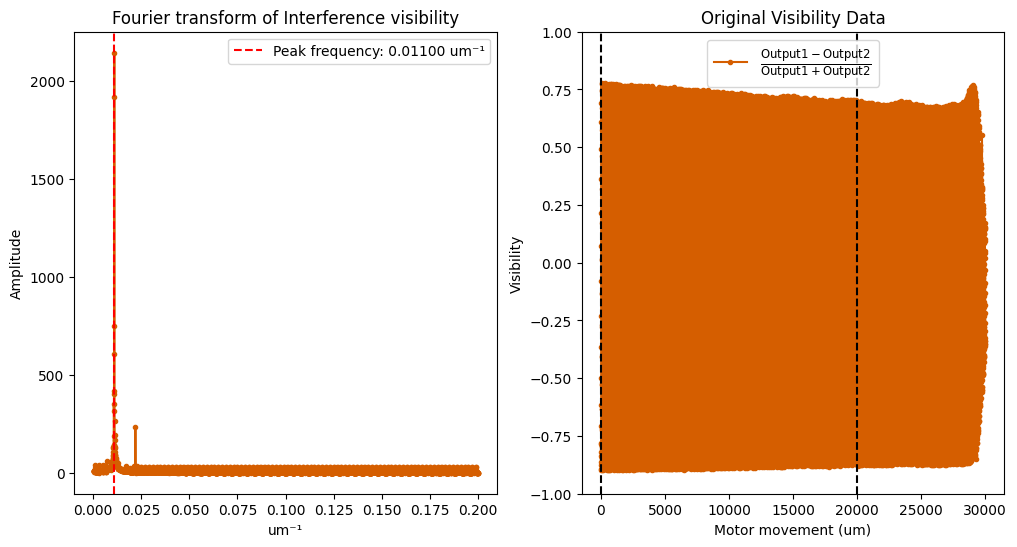

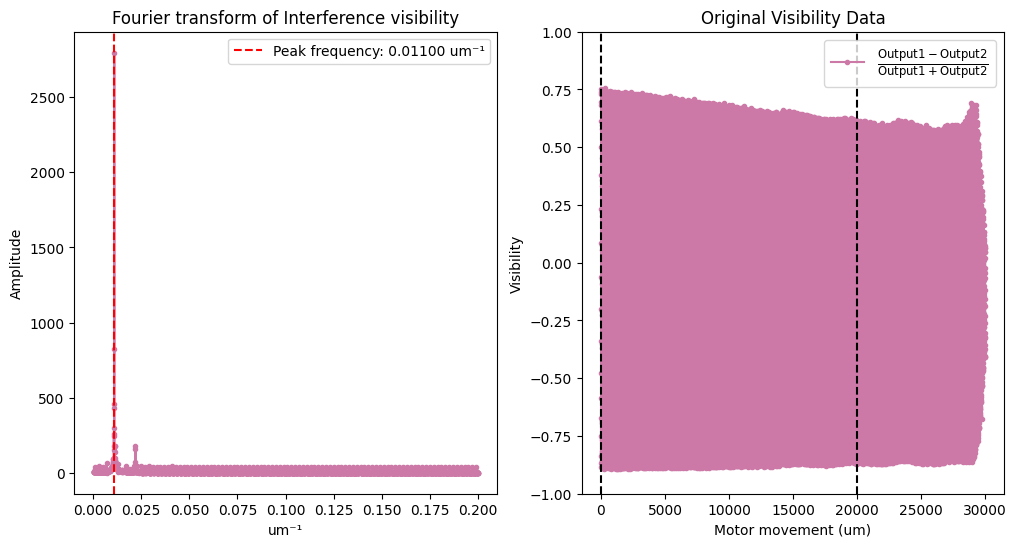

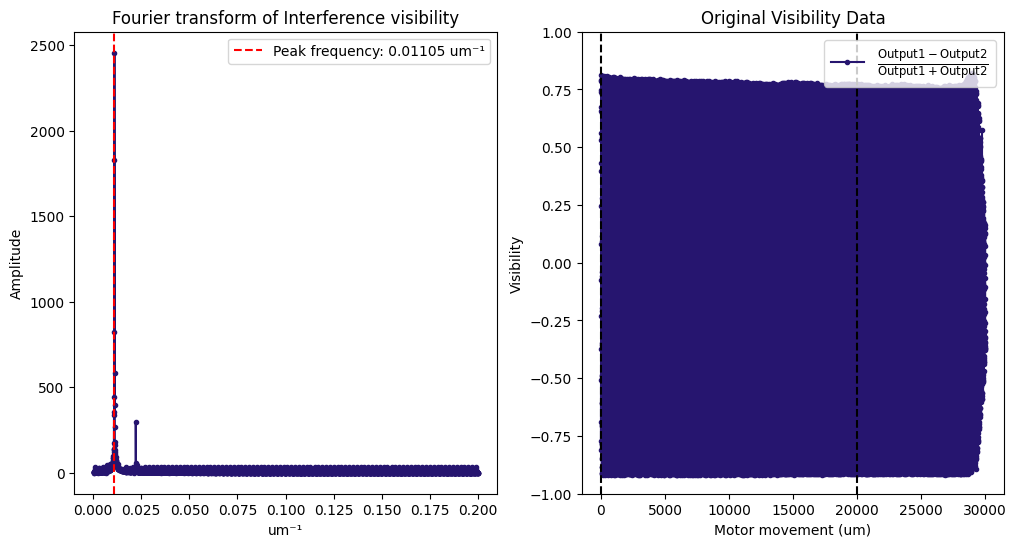

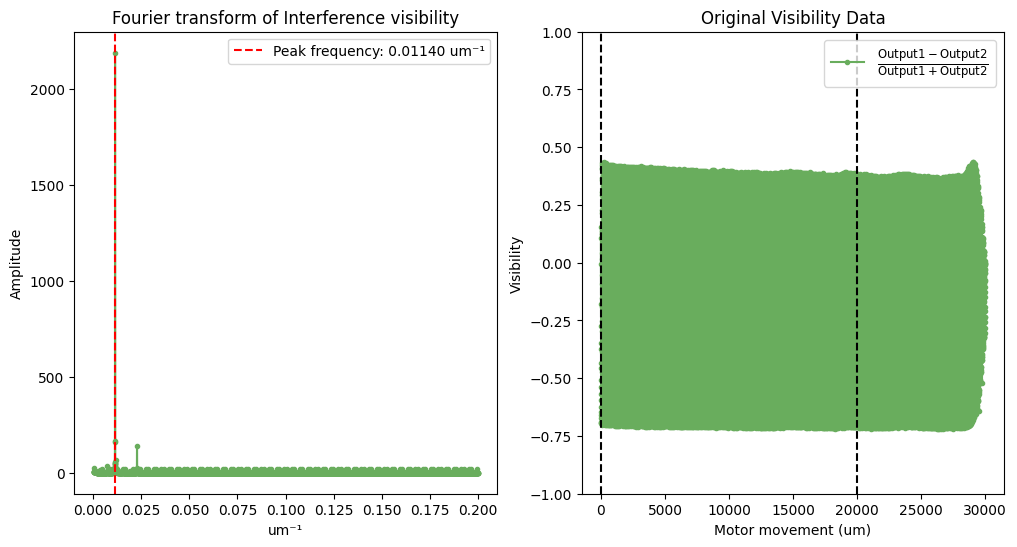

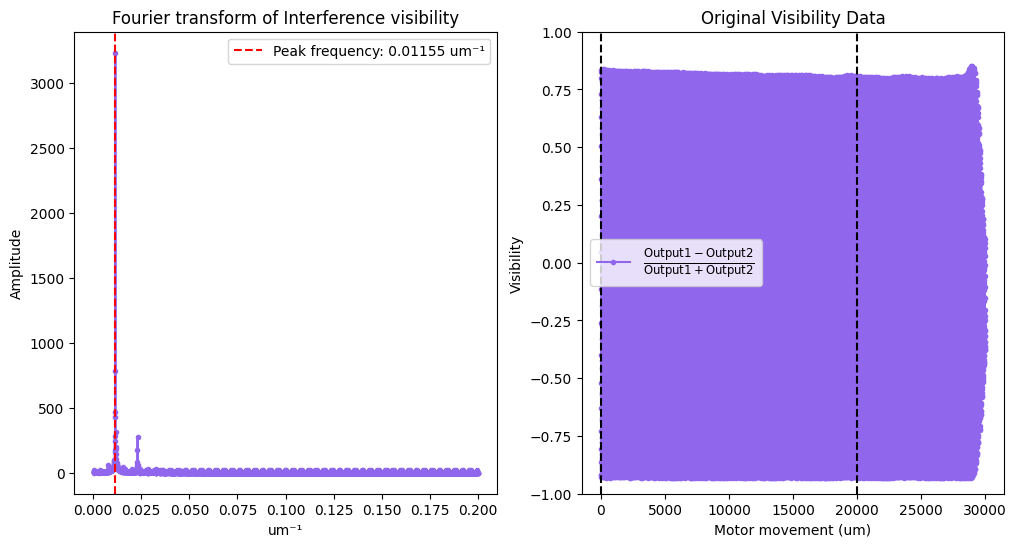

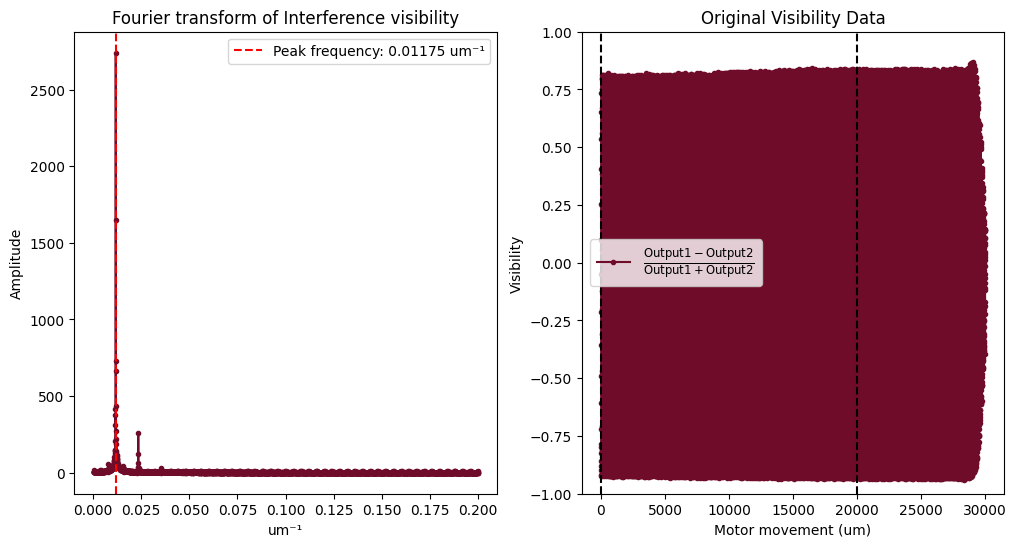

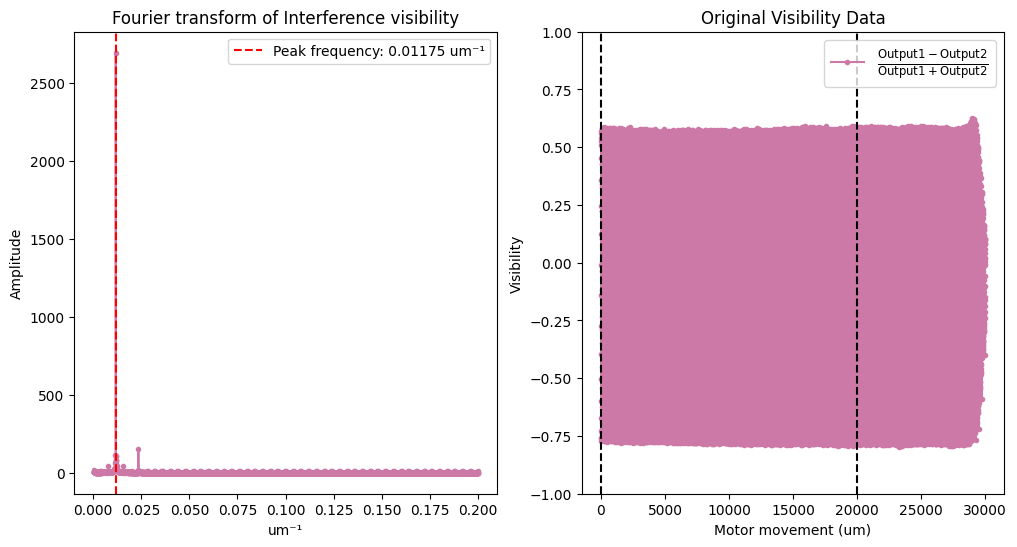

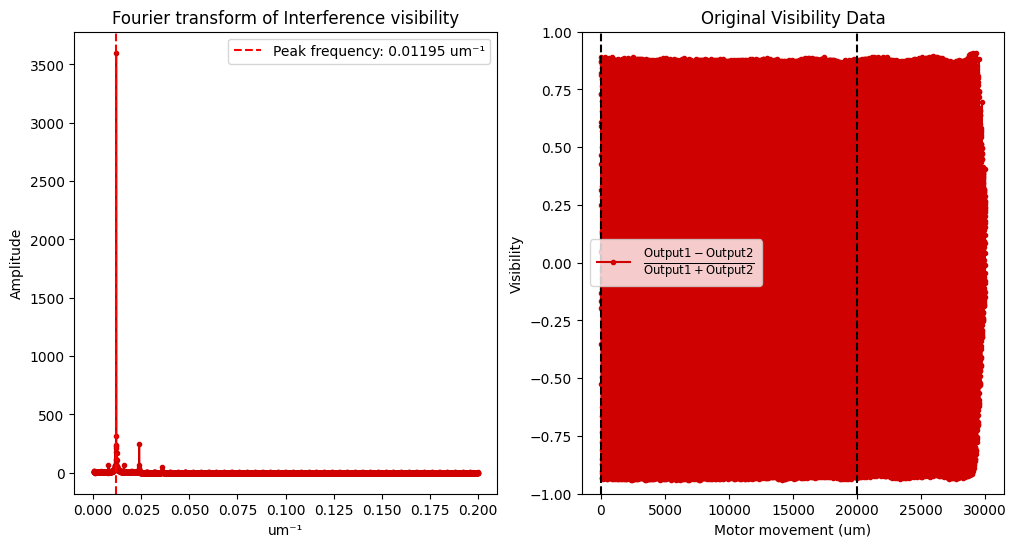

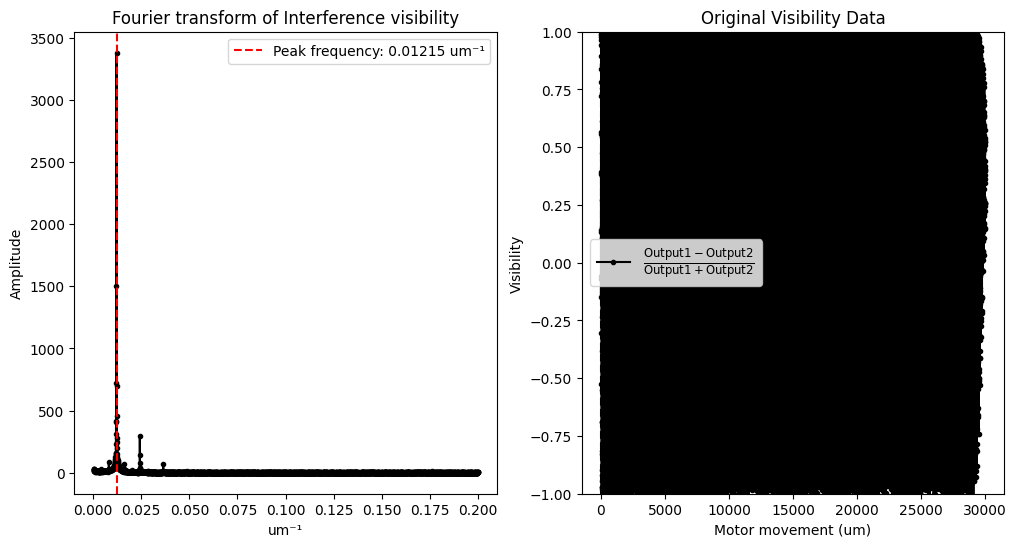

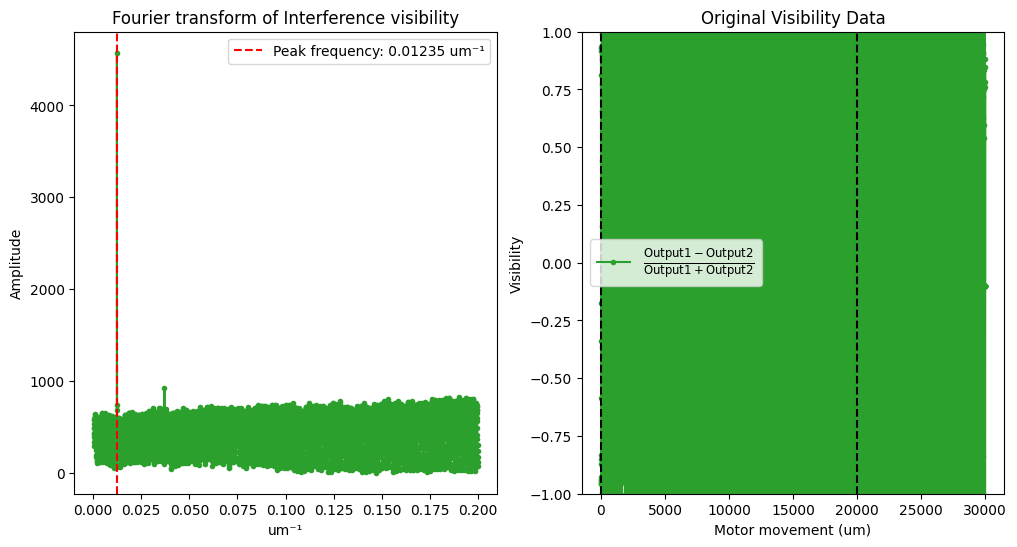

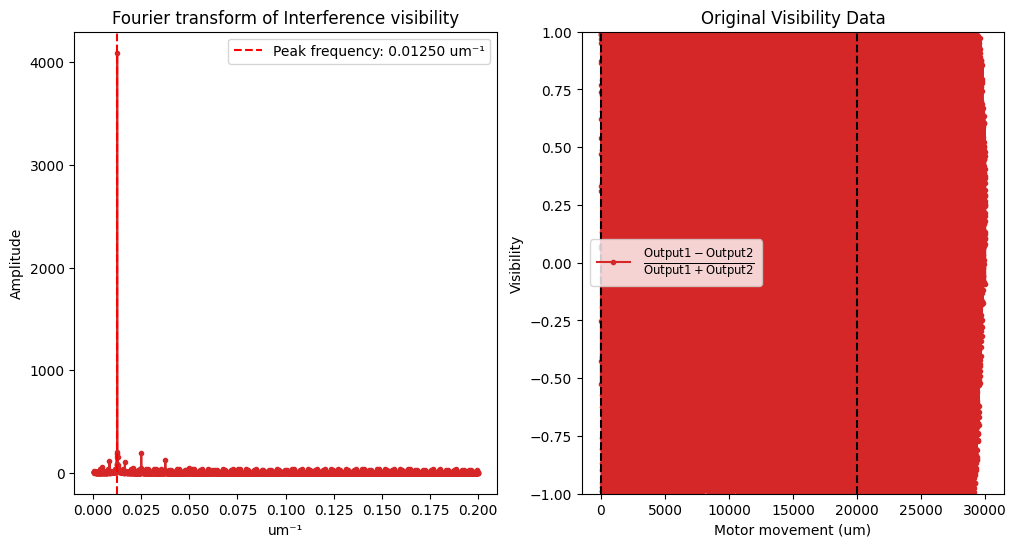

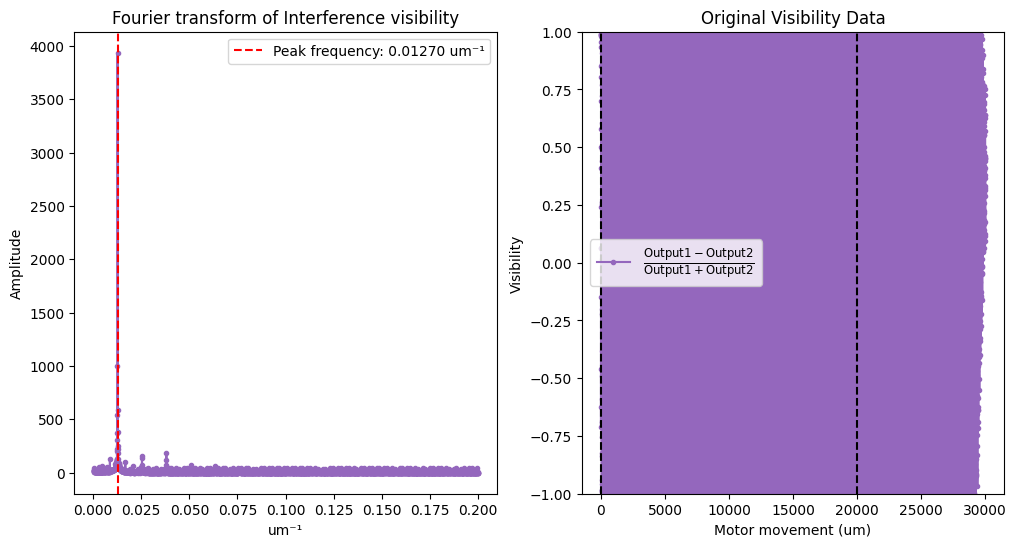

In [16]:
#exps = [] #expected fourier peaks, if we knew all the wavelengths
obss = []  #observed fourier peaks
#o1_fourier_peaks = []
#o2_fourier_peaks = []
vis_peaks = []
df = frequencies[4] - frequencies[3]
for i, spot in spot_df.iloc[::2].iterrows():
    fig, ax = plt.subplots(ncols=2,figsize=(12,6))

    
    # Below plots the modulus of the fft values, and doesn't display points after the nyquist frequency (negative values)
    ax[0].plot(frequencies[5:model_size//2], np.abs(spot['fft_vis_vals'][5:model_size//2]), marker='.', color=spot['display_color'])

    #int_freq = find_int_freq(spot['wavelength(nm)'])
    #exps.append(int_freq)
    #plt.axvline(x=int_freq, color='Black', ls='--', label=f'Expected interference frequency at {int_freq:.3f} {time_div_label}⁻¹')

    #finding the actual maximum value observed
    f_of_max_val = (np.abs(spot['fft_vis_vals'][5:model_size//2]).argmax() +5)* df
    obss.append(f_of_max_val)
    ax[0].axvline(x=f_of_max_val,color='red',ls='--',label=f'Peak frequency: {f_of_max_val:.5f} um⁻¹')

    vis_peaks.append( np.abs(spot['fft_vis_vals'][spot['fft_vis_vals'][5:model_size//2].argmax() +5]) )
    
    #plt.ylim(0, 25)
    ax[0].set_xlabel(f"um⁻¹")
    ax[0].set_ylabel("Amplitude")
    ax[0].set_title(f"Fourier transform of Interference visibility")
    ax[0].legend()

    # Time domain from before being modeled
    ax[1].plot(displacements, spot['vis_vals'], marker='.', color=spot['display_color'], 
             label=r"$\mathrm{\frac{Output 1 - Output 2}{Output 1 + Output 2}}$")

    ax[1].axvline(x=model_start, color='k', ls='--')
    ax[1].axvline(x=model_end, color='k', ls='--')

    ax[1].set_ylim(-1, 1)

    ax[1].set_title(f"Original Visibility Data")
    ax[1].set_xlabel(f"Motor movement (um)")
    ax[1].set_ylabel("Visibility")
    ax[1].legend(fontsize='large')

print(np.array(obss))

In [17]:
#add max frequencies to spot_df
obs_doubled = [obss[i//2] for i in range(2*len(obss))]
spot_df['vis_freq_max(inv um)'] = obs_doubled
spot_df

output  x_start  y_start  x_end  y_end display_color     exp wl  x_center  \
0        1      946     1151    980   1162       #000000  852.14411     963.0   
1        2     1210     2040   1230   2051       #000000  852.14411    1220.0   
2        1     1180     1158   1212   1169       #2ca02c  842.00000    1196.0   
3        2     1445     2041   1472   2062       #2ca02c  842.00000    1458.5   
4        1     1221     1160   1249   1169       #d62728  826.45215    1235.0   
5        2     1489     2044   1509   2063       #d62728  826.45215    1499.0   
6        1     1570     1170   1599   1182       #9467bd  811.00000    1584.5   
7        2     1844     2053   1868   2074       #9467bd  811.00000    1856.0   
8        1     1933     1177   1965   1199       #ff7f0e  801.00000    1949.0   
9        2     2213     2059   2240   2086       #ff7f0e  801.00000    2226.5   
10       1     1968     1179   1989   1195       #D00101  794.00000    1978.5   
11       2     2246     2065   2268   2085       #D00101  794.00000    2257.0   
12       1     2187     1186   2206   1204       #D55E00  794.00000    2196.5   
13       2     2466     2071   2485   2091       #D55E00  794.00000    2475.5   
14       1     2210     1186   2226   1204       #CC79A7  772.37600    2218.0   
15       2     2491     2072   2510   2092       #CC79A7  772.37600    2500.5   
16       1     2349     1190   2371   1210       #26156F  763.51054    2360.0   
17       2     2630     2074   2656   2096       #26156F  763.51054    2643.0   
18       1     2903     1206   2925   1228       #69AD5D  750.38680    2914.0   
19       2     3184     2091   3215   2113       #69AD5D  750.38680    3199.5   
20       1     3121     1208   3149   1237       #9066ed  738.00000    3135.0   
21       2     3398     2089   3445   2124       #9066ed  738.00000    3421.5   
22       1     3426     1225   3444   1244       #6F0C29  738.00000    3435.0   
23       2     3709     2106   3731   2127       #6F0C29  738.00000    3720.0   
24       1     3451     1225   3470   1243       #CC79A7  727.00000    3460.5   
25       2     3738     2106   3758   2125       #CC79A7  727.00000    3748.0   
26       1     3752     1235   3767   1252       #D00101  727.00000    3759.5   
27       2     4031     2119   4054   2132       #D00101  727.00000    4042.5   
28       1     4029     1245   4040   1257       #000000  714.70410    4034.5   
29       2     4310     2129   4323   2137       #000000  714.70410    4316.5   
30       1     4343     1257   4350   1264       #2ca02c  706.00000    4346.5   
31       2     4621     2139   4631   2145       #2ca02c  706.00000    4626.0   
32       1     4538     1262   4549   1271       #d62728  706.00000    4543.5   
33       2     4808     2144   4830   2152       #d62728  706.00000    4819.0   
34       1     4788     1269   4800   1279       #9467bd  696.54300    4794.0   
35       2     5057     2151   5075   2159       #9467bd  696.54300    5066.0   

    y_center                                          hist_vals  \
0     1156.5  [473.7881, 450.90033, 420.95642, 307.3954, 277...   
1     2045.5  [513.993, 526.05896, 575.09204, 555.76196, 591...   
2     1163.5  [1276.3888, 1184.4944, 982.5472, 633.01917, 52...   
3     2051.5  [2351.291, 2480.4612, 2758.5461, 2770.6958, 29...   
4     1164.5  [707.5738, 660.6494, 562.6872, 391.3092, 362.4...   
5     2053.5  [1784.897, 1857.011, 1991.068, 1903.498, 1990....   
6     1176.0  [1236.3162, 1139.4207, 970.4728, 677.9508, 601...   
7     2063.5  [3335.1475, 3416.2988, 3704.3745, 3555.6184, 3...   
8     1188.0  [9634.777, 9634.988, 9502.095, 8250.038, 7945....   
9     2072.5  [2961.2314, 2971.4502, 3200.5596, 3484.4658, 3...   
10    1187.0  [1503.0984, 1610.1992, 1839.2495, 2001.7456, 2...   
11    2075.0  [3666.9858, 3511.118, 3177.184, 2346.524, 2076...   
12    1195.0  [499.20728, 426.30994, 326.3612, 218.8482, 227...   
13    2081.0  [4177.897, 4240.0107, 4400.068, 4012.498, 3987...   
1

Text(0, 0.5, 'Wavelength (nm)')

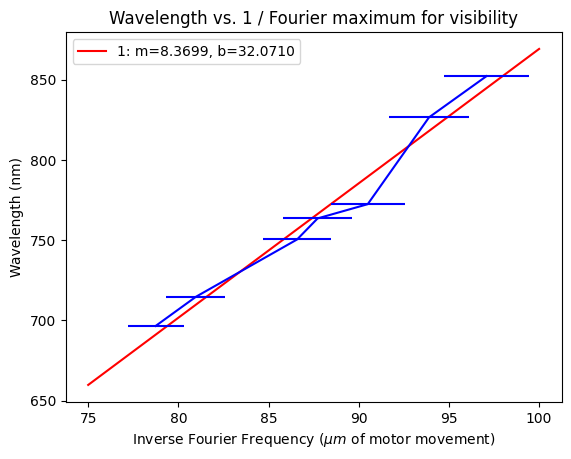

In [18]:
#NIST says it gives its wavelengths in AIR! However, this correction is small compared to other errors.
base_wls = [852.14411, 826.45215, 772.376, 763.51054, 750.3868, 714.7041, 696.543] #the uncontroversials
base_inv_freqs = 1./np.array([0.0103, 0.01065, 0.01105, 0.0114, 0.01155, 0.01235, 0.0127])
freq_unc = np.ones((7)) * 0.00025
inv_freq_unc = freq_unc * base_inv_freqs**2

def lineal_func(x, m, b):
    return m*x + b

popt, pcov = curve_fit(lineal_func,base_inv_freqs,base_wls)

xs = np.linspace(75,100,2)
fig, ax = plt.subplots()
ax.plot(xs,lineal_func(xs,popt[0],popt[1]),label=f'1: m={popt[0]:.4f}, b={popt[1]:.4f}',color='red')
ax.errorbar(base_inv_freqs,base_wls,xerr=inv_freq_unc,color='blue')
ax.set_title('Wavelength vs. 1 / Fourier maximum for visibility')
ax.legend()
ax.set_xlabel('Inverse Fourier Frequency ($\mu m $ of motor movement)')
ax.set_ylabel('Wavelength (nm)')

#print(pcov)

The resolution's just not there. Maybe the fits will be better.

#### Save spot_csv and displacements

In [52]:
#FIXME: This doesn't transfer over the lists in the above csv.
# It'd be nice (not strictly necessary) to do that. Perhaps using a really big dataframe.
spot_df.to_csv('f25A_Ar/spot_csv_ASI183_f25A_first8000FT.csv')

In [53]:
np.save("f25A_Ar/displacements_f25A", displacements)

### Discussion

What's with those anticorrelated kinks in the signal, which seem to stay within the confines of the signal amplitude? I have no idea. It could be something with the motors?

What's with the long-time undulating variation in the signals? I have no idea. Note that it starts *before* the second motor.

We want to know what wavelengths we have. How? The answer (if it's to be found in this notebook) involves a more precise FT (many more fringes, so a different setup). I also didn't do back-reflecting or precise measurements of the setup optics, so there's eventually some inaccuracy from that.